# Calculate Intra-Calo Timing Offsets 
Using $\Delta$t information provided by Jason Hempstead, M.Sc.

In [1]:
import ROOT as r
import numpy as np
from matplotlib import pyplot as plt

Welcome to JupyROOT 6.12/06


In [2]:
%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = 12, 6

In [6]:
# load input histograms
#in_f = r.TFile('totalDeltaTStudy.root')
in_f = r.TFile('./data/gm2deltaTAnalysis_full.root')
n_calos = 24
n_xtals = 54
n_rows = 6
n_cols = 9
calo_3ds = [in_f.Get(f'neighboringCrystalsDeltaT/hitDeltaT{i}') for i in range(n_calos)]

In [7]:
r.gStyle.SetOptStat(0)
r.gStyle.SetOptFit(1)

In [8]:
hist_dict = {}
def get_dt_hist(calo, xtal1, xtal2, fit_opt=''):
    try:
        return hist_dict[(calo, xtal1, xtal2)]
    except KeyError:
        calo_3d = calo_3ds[calo-1]
        calo_3d.GetXaxis().SetRange(xtal1+1, xtal1+1)
        calo_3d.GetYaxis().SetRange(xtal2+1, xtal2+1)
        hist = calo_3d.Project3D(f'z_{calo}_{xtal1}_{xtal2}')
        hist.SetTitle(f'calo {calo}, xtal{xtal1} - xtal{xtal2}; #Deltat [c.t.];')
        
        # fit the hist if it has more than 100 entries
        if hist.GetEntries() > 100:
            mean = hist.GetMean()
            std = hist.GetRMS()
            hist.Fit('gaus', 'q'+fit_opt, '', mean - 2*std, mean + 2*std)
            hist.GetXaxis().SetRangeUser(mean - 4*std, mean + 4*std)
            hist.GetFunction('gaus').SetLineColor(r.kRed)
            
        hist_dict[(calo, xtal1, xtal2)] = hist
        return hist

### Make sure output is as expected. (1,1,0) and (1,0,1) should appear equal and opposite in sign.

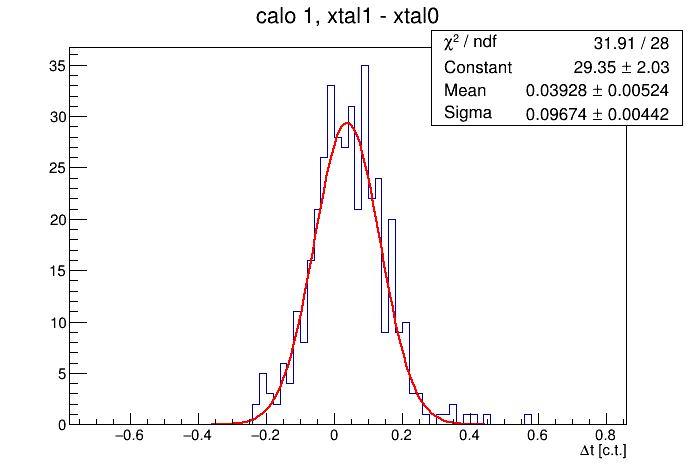

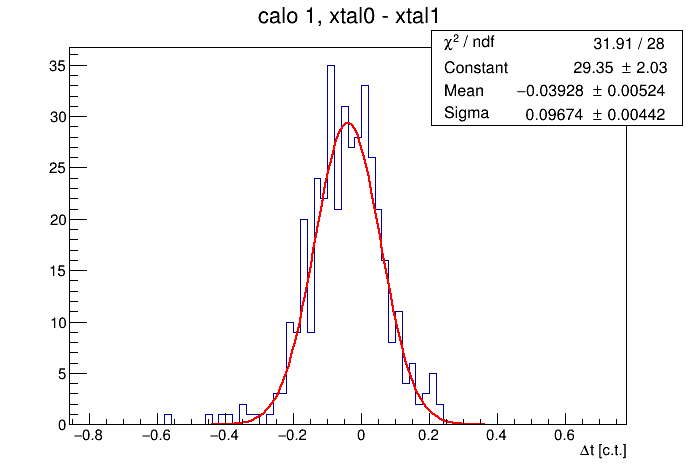

In [9]:
c1 = r.TCanvas()
h1 = get_dt_hist(1,1,0)
h1.Draw()
c1.Draw()
c2 = r.TCanvas()
h2 = get_dt_hist(1,0,1)
h2.Draw()
c2.Draw()

### Almost but not quite... Master Jason informs me that difference is based on energy cuts employed in the art analyzer

In [10]:
# function to solve for the offsets
# include diagonals: whether to include the delta_ts from diagonal neighbors
# start_corner: 'br', 'bl', 'tl', 'tr', for bottom-right, bottom-left, etc
# determines which crystal to start with, and accordingly which crystals count as central
# when pulling the DT histograms
def solve_dts(calo_num, fixed_xtal_num=0, include_diagonals=False, start_corner='br'):   
    if not 1 <= calo_num <= n_calos:
        raise ValueError(f'{calo_num} is an invalid calo number!')
    
    row_col_offsets = get_row_col_offsets(start_corner, include_diagonals)
    
    # build the list of equations
    weighted_rows = []
    weighted_dts = []
    for xtal_num in range(54):
        col, row = xtal_num % 9, xtal_num // 9
        for row_offset, col_offset in row_col_offsets:
            other_col = col + col_offset
            other_row = row + row_offset
            if 0 <= other_col < n_cols and 0 <= other_row < n_rows:
                other_xtal = other_row * 9 + other_col

                hist = get_dt_hist(calo_num, xtal_num, other_xtal)
                fit = hist.GetFunction('gaus')

                # only include this pair if a fit occurred
                if fit:
                    delta_t = fit.GetParameter(1)
                    delta_t_err = fit.GetParError(1)
                    
                    weighted_dts.append(delta_t/delta_t_err)
                    weighted_rows.append(np.zeros(n_xtals))
                    weighted_rows[-1][xtal_num] = 1
                    weighted_rows[-1][other_xtal] = -1
                    weighted_rows[-1] /= delta_t_err
                    
    matrix = np.vstack(weighted_rows)
    
    # remove the column for the fixed xtal num
    matrix[:, fixed_xtal_num:-1] = matrix[:,fixed_xtal_num+1:]
    matrix = matrix[:,:-1]
    
    solution, chi2, _, _ = np.linalg.lstsq(matrix, -1*np.array(weighted_dts), rcond=None)
    
    xtal_offsets = np.zeros(n_xtals)
    xtal_offsets[:-1] = solution
    xtal_offsets[fixed_xtal_num+1:] = xtal_offsets[fixed_xtal_num:-1]
    xtal_offsets[fixed_xtal_num] = 0
    
    return xtal_offsets, chi2

def get_row_col_offsets(start_corner, include_diagonals):
    if start_corner == 'br':
        if include_diagonals:
            row_col_offsets = [(0, 1), (1, 1), (1, 0), (1, -1)]            
        else:
            row_col_offsets = [(0, 1), (1, 0)]
    elif start_corner == 'bl':
        if include_diagonals:
            row_col_offsets = [(0, -1), (1, 1), (1, 0), (1, -1)]
        else:
            row_col_offsets = [(0, -1), (1, 0)]
    elif start_corner == 'tr':
        if include_diagonals:
            row_col_offsets = [(0, 1), (-1, 1), (-1, 0), (-1, -1)]
        else:
            row_col_offsets = [(0, 1), (-1, 0)]
    elif start_corner == 'tl':
        if include_diagonals: 
            row_col_offsets = [(0, -1), (-1, 1), (-1, 0), (-1, -1)]
        else:
            row_col_offsets = [(0, -1), (-1, 0)]
    else:
        raise ValueError('start_corner must be "bl", "br", "tl", or "tr"!')
        
    return row_col_offsets

### Function to check how well these constants actually do at equalizing the time differences

In [11]:
def compare_dts(calo_num, fixed_xtal_num=0, start_corner='br'):
    offsets, chi2s = solve_dts(calo_num, fixed_xtal_num, 
                               include_diagonals=False, start_corner=start_corner)
    
    before_dts = []
    after_dts = []
    
    # just plot neighbors, 
    # the diagonals seem to cause problems
    row_col_offsets = get_row_col_offsets(start_corner, False)
    
    for xtal_num in range(54):
        col, row = xtal_num % 9, xtal_num // 9
        for row_offset, col_offset in row_col_offsets:
            other_col = col + col_offset
            other_row = row + row_offset
            if 0 <= other_col < n_cols and 0 <= other_row < n_rows:
                other_xtal = other_row * 9 + other_col
                hist = get_dt_hist(calo_num, xtal_num, other_xtal)

                fit = hist.GetFunction('gaus')
                if fit:
                    before_dts.append(fit.GetParameter(1))
                    new_dt = fit.GetParameter(1) + offsets[xtal_num] - offsets[other_xtal]
                    after_dts.append(new_dt)
    return np.array(before_dts), np.array(after_dts)

[ 1.46700310e-03 -1.19714782e-03  1.97693481e-03 -1.94002175e-03
 -3.17350565e-04  2.92210441e-03 -6.13770204e-04  1.71295095e-05
  4.63315712e-03 -2.56303657e-03  5.11606281e-04  2.03131885e-03
  9.88636888e-03 -3.50315635e-03  5.57687628e-02 -3.23618206e-04
  1.26367245e-02 -3.94877574e-03  6.65878418e-03 -2.59144062e-03
 -3.51451028e-03 -4.95474333e-04 -1.34241121e-03 -2.34783590e-04
 -3.71517158e-04 -1.21740665e-03 -8.35127211e-05  3.15311811e-03
 -4.03119355e-03  4.86683080e-04  1.18021069e-03  1.90712987e-03
 -9.26815966e-04  2.56283846e-03  1.80254502e-03  1.63710200e-03
 -3.32080051e-03  8.48772243e-03 -3.47505667e-03 -2.09262612e-04
 -2.65791045e-03 -1.32223846e-03  1.19776171e-04 -4.47637632e-03
 -7.86157801e-05 -3.62332017e-03 -7.88002971e-04  1.97615517e-03
 -2.46668243e-03  1.51124691e-03 -8.12181395e-04  1.31520043e-03
 -1.10641425e-03  5.73014961e-03 -2.14880231e-03  4.00496146e-03
  8.46878644e-04  1.61278152e-03  3.69609318e-03  1.12034753e-03
 -4.31747177e-03 -3.05252

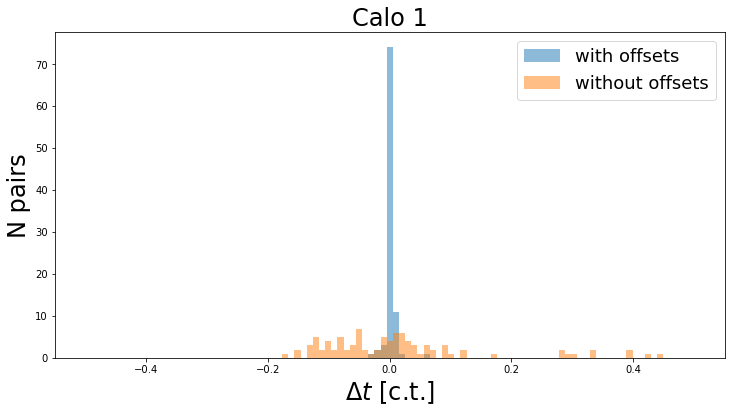

[ 4.16044438e-03 -6.50376469e-03  4.62971558e-03 -5.21584958e-03
  5.30907601e-03  9.32406525e-04  3.88363153e-04  5.78505968e-03
  5.51447194e-03 -4.00781644e-03  3.15968998e-03  2.66757438e-03
  2.56196069e-03  1.09633795e-03 -1.63291803e-02  2.35064478e-03
 -3.71810419e-03  1.16775028e-03 -4.74637464e-03 -8.72163811e-04
  2.09149643e-04  2.43451982e-03 -5.21585433e-03  4.67497122e-03
  3.51889507e-04  5.08641337e-03 -2.13446442e-03  1.58259877e-03
  4.83188391e-03 -6.35354994e-05  2.26066642e-03  1.20854775e-03
 -3.73102282e-04  4.59408698e-04 -1.93762499e-04 -3.97591789e-03
 -2.09412411e-03  5.25098980e-03 -6.11873248e-03  4.84761230e-03
 -5.75924515e-03  5.90227358e-04 -4.32403265e-03 -4.50881916e-03
 -3.50699531e-03  3.77219452e-03 -3.72927132e-03  2.24520433e-03
 -7.60658045e-05 -5.80971064e-03  3.09114273e-04 -7.76029047e-04
 -2.07904009e-03 -2.77983613e-03  9.12819896e-03 -7.06165357e-04
  1.46806043e-03 -2.87625570e-05 -5.99851318e-04 -2.12097906e-03
 -7.06934068e-05 -2.85347

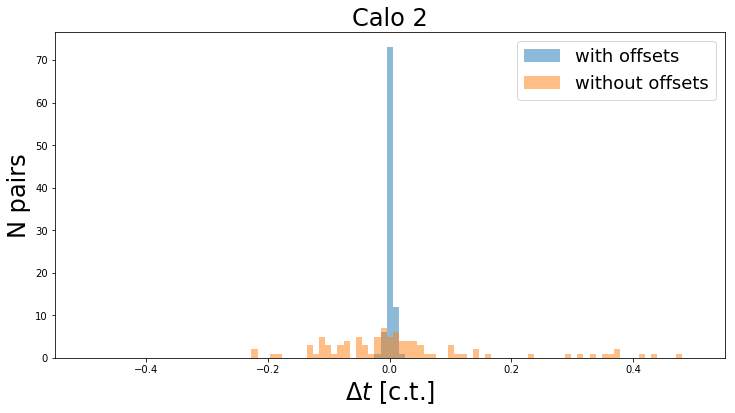

[ 3.20700323e-03 -4.69142031e-03  5.92615159e-03 -4.77165062e-03
  2.75625337e-03  4.99597987e-03  1.53168208e-03  2.10871422e-03
  1.16156636e-03  4.38170868e-04  4.20903811e-03 -1.89963086e-03
  7.99293606e-03  6.17132481e-04  2.41664621e-02 -2.34586161e-04
  5.32670344e-03  2.08546927e-03 -4.96171328e-03  2.47500624e-03
 -4.05665686e-03  3.94397683e-03  2.07109270e-04  1.76219258e-03
  4.96578952e-03  5.19415529e-03 -3.99536216e-03  4.96247524e-04
  4.29595020e-03  4.83416117e-03 -4.17307277e-03  2.07124547e-03
  2.47535865e-03  1.82875187e-03 -1.68451689e-03 -1.76546544e-03
 -7.63426506e-03  1.02274156e-02 -6.28170009e-03 -2.33124936e-03
 -1.86960417e-04 -5.67502821e-03 -1.32565214e-03 -1.83853030e-03
 -1.04568630e-03  3.36698887e-03 -3.50227515e-03 -3.29427301e-04
 -2.96528101e-03  2.43250975e-03 -1.62017047e-03 -1.96344011e-03
  1.18598448e-03  2.37197284e-03  1.70550534e-04 -5.91978698e-04
  3.50725480e-03 -2.46924676e-03 -1.57598705e-03 -4.53068889e-03
  1.64729820e-03 -3.49524

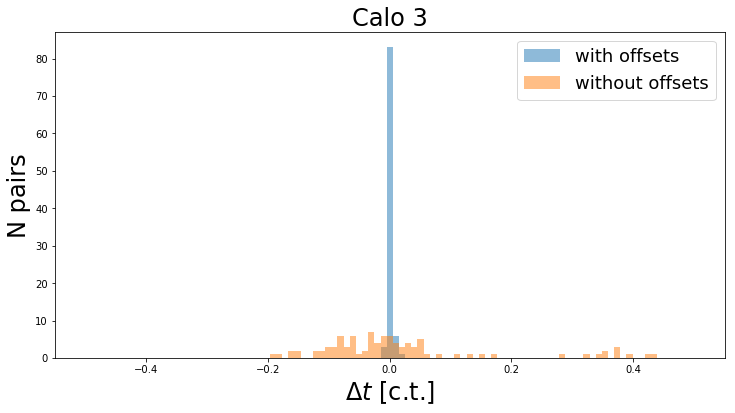

[ 1.95420348e-03 -1.87474166e-03  8.51211088e-04 -3.74823608e-04
  2.64970651e-03 -2.33679832e-03  2.35239308e-03  1.45024878e-03
 -1.27582222e-03  3.02464106e-03  5.84468628e-03 -2.83158032e-03
  6.90479264e-03  9.18639462e-05  7.21342047e-03  2.68080416e-03
  1.39289736e-03  1.08045727e-05 -5.95319746e-04  1.09973075e-03
 -2.53675081e-03 -9.47944649e-05  3.50113518e-04  6.01716825e-03
 -7.53460861e-03  1.80699911e-03  5.72466359e-03  2.64491031e-03
 -2.90860416e-03  2.85957987e-03 -2.80528792e-05  1.48601993e-03
  2.46383961e-03  1.02099896e-03  2.71738014e-03 -8.21880739e-03
  2.69165711e-03 -2.75237172e-03  2.17819133e-03  1.14879228e-03
 -1.39990033e-03  7.31822128e-05  1.16888682e-03  1.34844971e-03
 -6.15347333e-04 -1.12962440e-04 -1.00048976e-04 -7.16675379e-04
  2.64691761e-03 -2.18159737e-03  3.71288274e-03 -1.73892793e-03
 -4.03451363e-03 -7.32858041e-03  1.07762906e-02 -6.44341640e-03
 -2.72357991e-04 -7.00191425e-03  2.73148660e-03 -6.65370288e-03
  3.13146415e-03 -5.35816

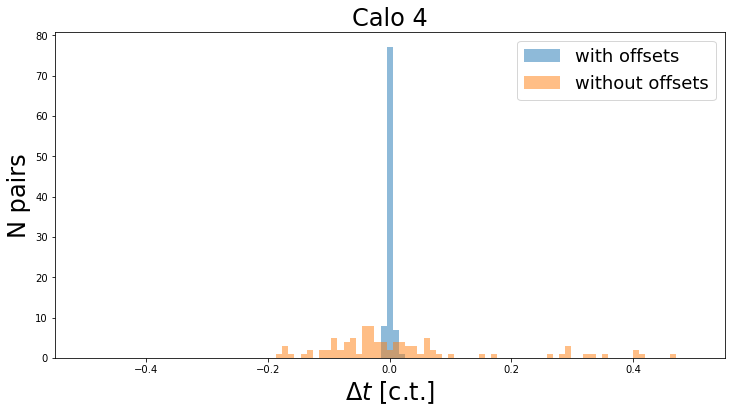

[ 6.91211023e-03 -1.21356253e-02  1.24630040e-02 -1.46187041e-02
  1.00426673e-02  8.38295323e-03 -4.85060428e-03  1.56182257e-02
 -5.84179125e-03 -4.19230114e-04  5.84155746e-03 -6.87513326e-03
 -8.35572216e-04  2.93039875e-03  1.51873419e-02 -2.60401481e-03
  1.44702900e-02 -7.09869177e-03  1.03560862e-02 -2.51502057e-02
  1.92727073e-02 -2.30865891e-02  4.06458643e-03 -7.34775164e-03
 -1.08802484e-02 -5.85256080e-04 -8.55831000e-03  1.13006367e-03
 -3.93410207e-03  8.28964293e-03 -5.77687033e-03  1.69762553e-03
  5.98309456e-03  1.55519042e-03  3.66628995e-03 -1.17753508e-03
  9.68140485e-03  9.73632020e-03  8.48308027e-03  2.99230993e-03
  4.07223721e-03 -4.06445199e-03  2.34784645e-03 -6.76835136e-03
 -1.40953632e-03  2.34191558e-03 -3.72821073e-03 -1.05513845e-03
 -1.64379430e-03  1.25515390e-03 -4.73446941e-04 -8.50376318e-04
  8.37859507e-04  3.31405506e-03 -1.07472618e-03  4.25533979e-03
 -8.80377657e-04  2.66666133e-03 -7.75650716e-04 -1.63396307e-04
 -4.58029367e-04 -1.90944

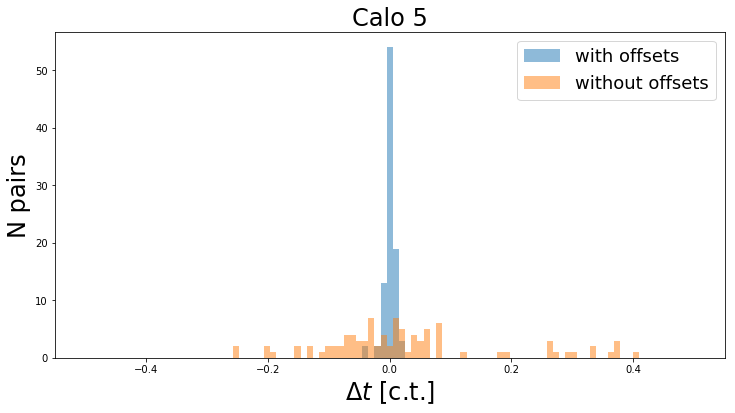

[-1.12694159e-02  2.16307783e-02 -1.48798103e-03 -1.90276375e-03
 -4.83035380e-03  4.40291311e-03 -2.72219305e-03 -3.89288665e-03
  3.55363064e-03 -5.39536676e-03 -9.97048790e-03  7.54387379e-03
  3.06685668e-02 -1.50539577e-02  4.45734028e-02  5.29338234e-03
  2.43993007e-02 -3.93771318e-04  6.31770831e-03 -1.79366897e-03
  1.62630547e-03  2.20733342e-03 -4.08601751e-03  3.19274713e-03
 -5.18679157e-03  2.70937182e-03 -1.78560755e-03  2.68245435e-03
  3.38464959e-03 -5.35930022e-04 -1.53389020e-03  1.35814970e-03
 -6.23646514e-04  2.70360628e-03  1.33022057e-03  3.63417185e-04
  1.76852103e-03  8.95956837e-04  6.87994269e-04 -2.33302965e-03
  1.87350977e-03 -5.73933496e-03  2.70497317e-03 -3.85713251e-03
  2.34276203e-03  3.74236098e-03 -9.34260876e-04  4.71003096e-03
 -2.96618311e-03  2.65642141e-03 -1.04550301e-03  9.42295918e-04
 -1.84388112e-03  5.96289410e-05  2.66148894e-03 -4.43883066e-03
  8.64999727e-03 -6.25815862e-03 -4.51203183e-03 -4.01046229e-03
 -7.27132761e-03  2.19411

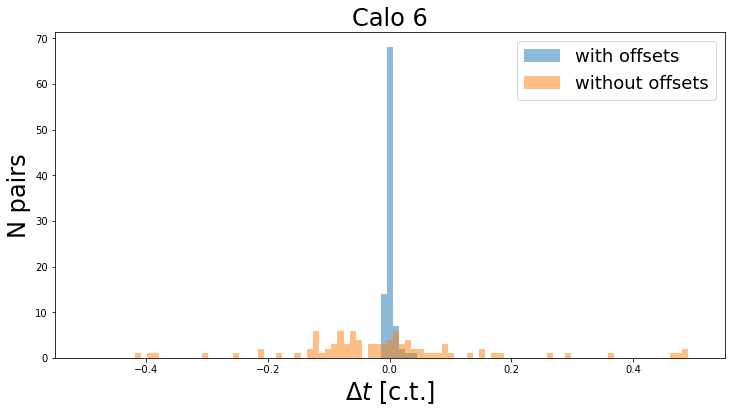

[ 3.74868166e-03 -4.68385776e-03 -5.78153885e-03  9.16230421e-03
 -2.96402729e-03 -4.64906466e-03  3.31829204e-03 -4.72360024e-03
  4.36856329e-03  2.20257588e-04  3.49349852e-03  1.32349733e-03
  1.46037591e-02 -3.38734192e-03  2.68230938e-02  5.04897313e-03
  8.80207999e-03 -2.26747691e-03  2.93221987e-03 -9.21467408e-04
  5.25957720e-03  5.48593483e-04 -5.65063446e-03  1.08005191e-04
 -2.43543241e-03  5.15213922e-03 -5.61844834e-03  1.16296879e-03
  5.05580899e-03 -9.76562221e-04  5.87413624e-04  2.48605240e-03
 -2.14431605e-03  2.45497669e-03  1.38680347e-03 -6.46716781e-04
  9.74773275e-04  6.15753581e-03 -9.71204577e-04 -1.76362022e-03
 -1.77208913e-03 -2.92539814e-04 -2.53633005e-03 -3.77623379e-03
 -1.37562482e-03  2.40239775e-03 -1.67682083e-03  1.29748543e-03
 -3.19479382e-03  1.17030892e-03 -1.81890770e-03 -4.46809871e-03
  8.37538901e-03 -1.21696315e-03 -5.13668974e-04 -1.53595744e-03
 -8.54611601e-04  5.71219673e-04 -4.96659876e-03 -1.93905175e-03
  1.09861984e-03 -8.85138

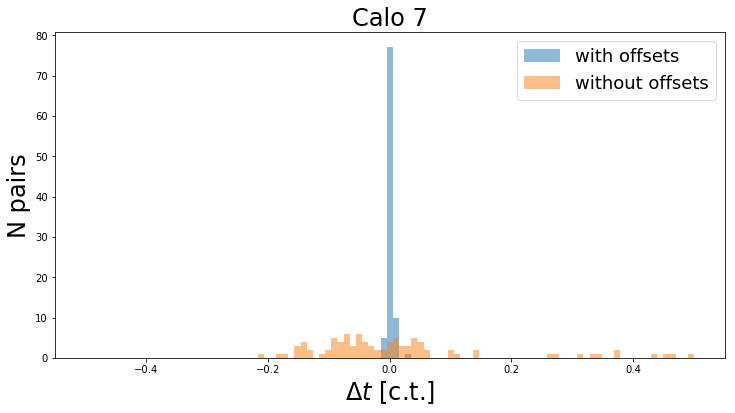

[-7.51369027e-03  6.53551497e-03  9.63814779e-04 -5.15743498e-03
  4.61181264e-03 -5.40117562e-03  1.04173447e-03  3.62750320e-03
  2.70793153e-03 -7.94153618e-04  6.65979863e-04  1.48275959e-03
  1.38410053e-03 -4.25014521e-05  2.61756637e-02 -3.93577569e-03
  1.30358700e-02  2.04350715e-03 -1.65488527e-03  3.37653687e-03
 -5.45180288e-03 -1.24383093e-04  3.00847745e-03  2.08638200e-03
 -6.77218648e-04  2.87809955e-03 -1.42492692e-03 -1.24413152e-03
  6.16015889e-03 -4.56616909e-03  3.15944966e-03 -5.26724668e-03
 -1.51780543e-03 -2.10785805e-03 -5.20224568e-04 -8.01902990e-04
 -2.44215730e-03 -8.96035232e-04 -2.12074563e-03  2.63728027e-03
 -2.06647312e-03 -6.48556583e-04 -6.34734752e-03  5.94935452e-03
  9.97903353e-04 -5.93227263e-03  1.09633014e-03  2.43972931e-03
  3.51382111e-04 -9.52581921e-05 -1.39158647e-03 -1.14017220e-03
  1.69163928e-03 -3.14588792e-03  3.67867138e-03 -6.07206756e-03
  8.42966491e-03 -2.95300769e-03 -4.27936467e-03 -2.30431222e-04
  1.86634149e-04 -2.98089

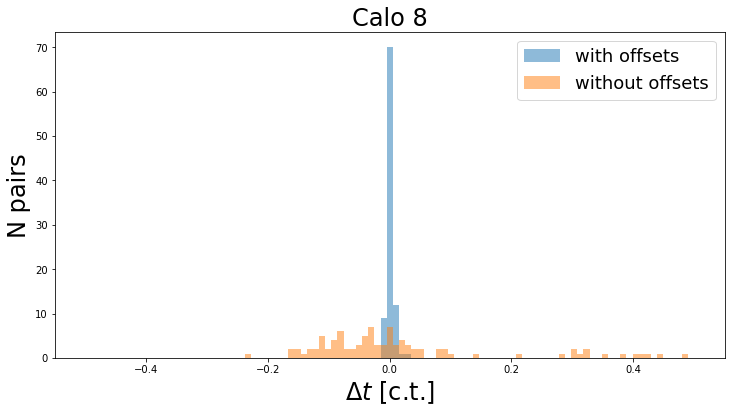

[-5.33251331e-03  8.01596427e-03  5.82540871e-03 -1.43773327e-02
  6.54723230e-03 -1.23484071e-03 -2.87527081e-05  8.37405953e-03
  3.06067080e-03 -2.01030329e-03  3.93293573e-04  1.26550508e-03
  1.01845045e-02 -2.26125729e-03  2.60669350e-02  1.40011269e-03
  4.49443970e-03 -2.13396788e-04  3.44443247e-03 -1.67680873e-03
 -5.12240464e-03 -4.28292159e-04 -3.23332654e-03 -6.45007176e-04
  5.72703221e-03  1.18573973e-03 -2.98177080e-03  1.78837221e-03
  2.70585450e-05  5.84298890e-03 -5.40438655e-03  2.12796938e-03
  3.30465423e-03  1.81621711e-03  1.03527161e-03  8.99509882e-04
 -3.95310297e-03  5.71492166e-03 -7.38635623e-03  4.27421884e-03
 -3.21735654e-03 -2.91783315e-04 -5.62302361e-03  1.72142426e-04
 -7.70533602e-03  4.33714838e-03 -8.59516740e-03 -4.94486959e-03
 -4.79941646e-03  1.58605445e-03 -3.64773797e-03  9.39525274e-04
 -1.17338254e-03  4.75937481e-04  6.24935756e-03  1.06706734e-03
  3.08778624e-03  1.36889030e-03 -9.38935236e-04  6.91183031e-04
  1.46515182e-03  3.23811

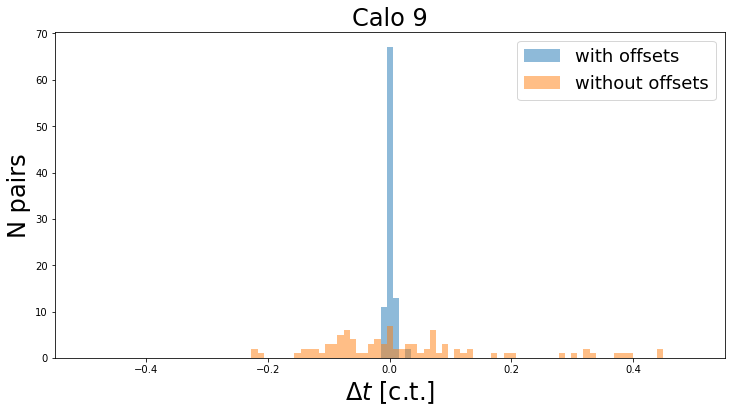

[-5.26663075e-03  5.51154663e-03 -3.12068370e-03  1.99909621e-03
 -1.44651128e-03 -1.70321482e-03 -5.23857057e-03  3.14382010e-03
 -1.29678438e-03 -3.47584876e-03 -1.94547905e-03  7.58174343e-05
  1.15094911e-02 -4.99524250e-03  1.36286544e-02  2.99905156e-03
  3.68444466e-03  2.91657218e-03 -2.62624492e-03  1.92073911e-03
  1.85650685e-03  7.68485298e-04 -7.47328041e-06  2.49808678e-03
 -8.01327928e-04  2.78195509e-03 -1.85540084e-03 -2.67376579e-04
  3.38767307e-03 -1.65434600e-04 -1.85910036e-03  2.83991016e-03
 -2.22407304e-03  2.16488605e-03 -5.68658691e-04 -1.30698856e-03
  8.57367296e-05  5.86755774e-04 -2.26945392e-04  8.22464339e-04
 -9.96881467e-04  6.34387498e-04 -3.16354752e-03  3.07139548e-03
 -2.47061026e-03  1.85810706e-03 -2.41306772e-03 -1.81416515e-03
 -3.25387017e-03  3.07201295e-04 -1.63611185e-03  1.75884604e-03
 -6.78821517e-03  1.18225215e-03  2.22238153e-03 -1.99281026e-03
  6.60020534e-03 -1.94935458e-03  1.55686363e-03 -1.96169452e-03
  2.62301829e-03  2.92095

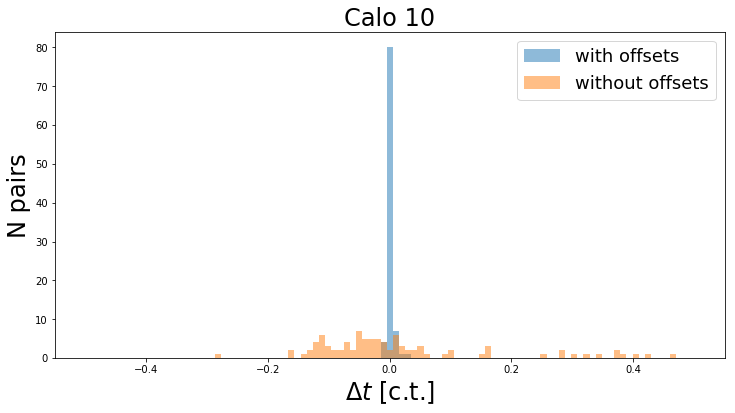

[-2.64812387e-03  3.90108994e-03  4.72454774e-03 -1.03144234e-02
  3.19005875e-03  2.74610758e-03  4.15319759e-03 -8.43646891e-05
  9.55080658e-03 -4.07465090e-03  1.04735769e-02  1.85450965e-03
  1.18703372e-02 -1.05322443e-04  3.02498288e-02  1.21483808e-03
  1.61953601e-02 -5.86195183e-04  2.17290592e-02 -1.87421576e-04
 -6.49599775e-03  2.66877186e-04  1.17878429e-03 -1.69251127e-03
  3.49297382e-03 -1.68425626e-03 -2.42981610e-03  1.07071494e-04
 -1.41444680e-03  2.39957544e-03 -2.71344439e-03  1.18919523e-03
  1.59222692e-03  1.99151552e-03  1.11445261e-02 -3.07626675e-03
 -8.95091090e-04 -2.24098938e-03 -9.55649351e-04  1.02077800e-03
  1.86474308e-03 -2.14062191e-03  6.29200361e-04 -4.15702976e-04
  1.89877766e-04 -5.33227126e-04 -3.11903492e-03  3.15499980e-03
 -2.78226002e-03  1.85955734e-03 -1.54266900e-03 -7.83493769e-04
  1.30253801e-03 -2.17369801e-03  1.21988501e-03  1.82830475e-05
 -3.14909840e-03 -1.93611583e-04 -1.94210640e-03 -1.13191201e-03
  1.57961505e-03 -1.39074

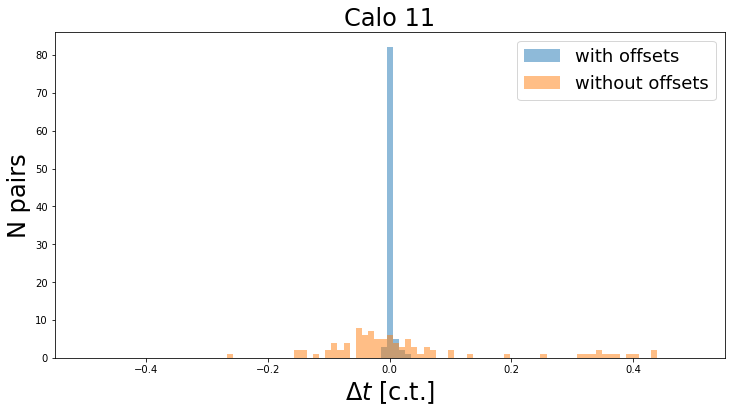

[-8.97910690e-03  1.37707202e-02 -2.37222816e-03 -1.43911032e-03
 -4.36854139e-03  1.01908283e-03 -3.63714176e-03 -2.09821648e-03
 -2.74142348e-03 -7.87909834e-04 -3.13122107e-03 -4.89476559e-05
  2.78151495e-03 -3.09051308e-03  6.56251883e-03  2.64668435e-04
  1.90873077e-03  2.62149494e-03 -9.29281845e-04  2.56009102e-03
 -1.61747016e-03  3.53168861e-03 -7.53850564e-04  2.30736184e-03
  1.01750345e-04  5.88688660e-03 -5.40105855e-03  1.42776306e-03
  4.59777163e-03  1.34489873e-03 -8.14380894e-04  2.01596609e-04
  9.45180771e-04  2.48859694e-04 -2.98387668e-03  5.40862908e-03
 -3.79961897e-03  1.92101189e-04 -2.63780489e-03 -1.26200211e-03
 -2.49252024e-03  1.40060358e-04 -4.16227849e-03 -2.63336485e-03
 -6.52546358e-06 -2.96906015e-04  6.48094031e-04 -1.85200101e-03
  6.82006228e-04  5.65284067e-04  9.96099711e-04  3.40082722e-03
 -2.66948354e-03  1.67778657e-03  3.80586565e-03  5.95182416e-05
  1.61869280e-03  6.80185595e-05  9.08116856e-05 -6.87270891e-04
 -1.87637799e-03 -1.41555

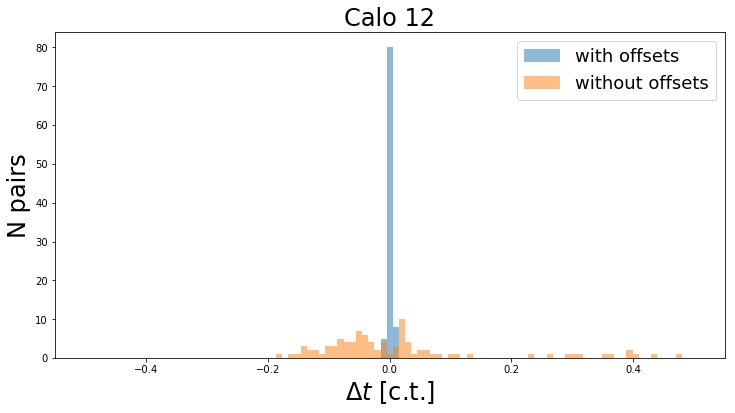

[ 1.94977359e-02 -2.28102877e-02  2.28148274e-02 -1.15635706e-02
  2.98666151e-02  7.87943610e-04  2.78644592e-02  2.34516963e-03
  3.31154109e-02  1.71736266e-03  3.85507883e-02  6.57862244e-03
  2.21562718e-02  2.27148189e-03  3.61303522e-02  3.85163945e-03
  1.71896978e-02 -6.05005210e-04 -7.78187948e-03 -3.03930115e-03
 -2.01948448e-03  1.11630280e-03 -5.47159780e-03  4.01929155e-03
 -4.18206705e-03  3.48892922e-03  1.05372915e-03  2.22657581e-03
  2.53624178e-03  1.24250223e-03  1.64503638e-03  5.67075852e-04
  1.43821095e-03  2.35417345e-03 -6.74788938e-03  6.12819963e-03
 -7.82372514e-03  4.68722612e-03 -7.44620413e-03 -6.02790646e-03
 -9.03435835e-03 -9.08708625e-04 -7.01266240e-03  7.70209953e-04
 -4.74079594e-03 -1.34742649e-03 -2.30032526e-03 -1.35537407e-03
 -1.63063072e-03  7.51107853e-04  2.70383138e-05 -9.51608629e-05
  6.76946475e-03 -1.77322886e-03  9.70499783e-03 -5.37799804e-03
  3.84065243e-03 -5.13544729e-03 -1.56767157e-03 -4.87787162e-03
  1.20219126e-03 -5.38224

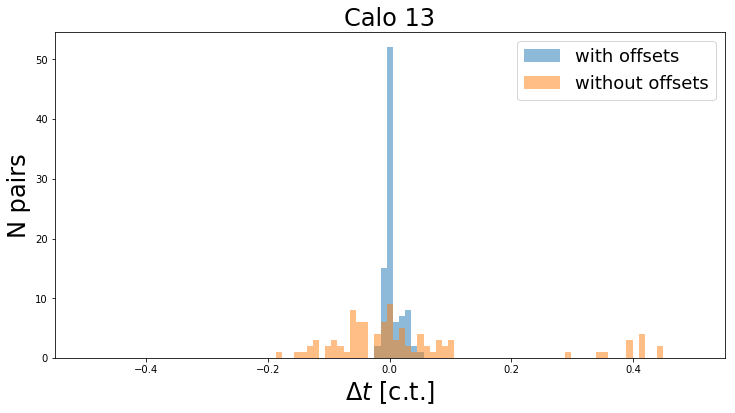

[ 3.50686926e-03 -4.13711394e-03  3.63755689e-03 -2.98889569e-03
  3.41052864e-03  1.22313794e-03  5.74349066e-03 -2.24659195e-03
  7.76712803e-03 -9.71270713e-05  1.03184085e-02  4.38518474e-05
  7.65798918e-03  2.93687061e-03  3.68708189e-03  2.88590667e-03
  1.30289246e-03  1.04534437e-04 -1.55192529e-03  2.54649799e-04
 -3.00715026e-03  3.90630037e-03 -4.75521305e-03  6.17832506e-03
 -5.61219054e-03  4.06477811e-03  2.68736702e-03  3.44005532e-03
  8.50090390e-04  5.36844088e-03 -5.22390500e-04  6.06892013e-03
  7.09111344e-04  3.71757959e-03  1.27264661e-04 -1.87137458e-03
 -2.26264834e-03  2.73129677e-03 -7.06177984e-03  6.33442954e-03
 -6.16236384e-03 -4.22472212e-03 -3.11139538e-03 -3.32217968e-03
 -2.64335613e-03  6.66729660e-04 -2.93430667e-03  6.94385411e-04
 -2.51876558e-03  2.43566186e-04  1.45875441e-04 -1.32229859e-03
  1.93651764e-03  1.76100756e-04 -1.13893830e-03  1.55342755e-03
  2.26148274e-03 -1.76143167e-04 -9.74181269e-04 -1.90953443e-03
  3.97266960e-04 -8.43321

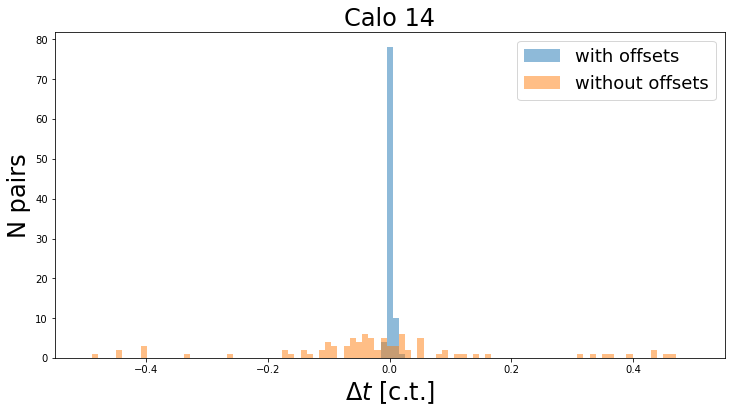

[-2.52009234e-04  2.99721559e-04 -1.53978224e-04  4.48711444e-04
 -4.56597109e-04  1.12622502e-03 -3.27832693e-04 -3.68764076e-03
  2.56396627e-03  7.85859387e-03 -4.02858032e-03 -9.59968771e-03
  3.60061624e-03 -2.01295537e-03  1.24911764e-04 -1.83073076e-04
 -3.59386521e-03  5.77584251e-03 -2.67790094e-03 -2.39384435e-03
 -5.06768247e-03  4.13894179e-03 -4.65544994e-03  6.54848714e-05
 -2.83902293e-03 -1.50873154e-03 -1.79679860e-03 -2.43533233e-03
 -5.16120982e-04 -2.14759728e-04 -5.05438578e-04 -1.65860940e-04
  1.89991180e-04  2.23081456e-03  1.28087764e-03  2.84917765e-04
  1.83788765e-03  1.96541092e-03  4.69431079e-04  2.45110360e-03
 -9.94947387e-04  6.02205567e-04  1.71181748e-03 -1.33321947e-03
  7.60893531e-04 -7.40519829e-04 -8.36753728e-04 -1.49708798e-03
  1.22141702e-03 -2.65497163e-03  9.42054274e-04  1.88817966e-03
  9.00895132e-04  1.77020937e-03  1.38321986e-03 -6.24399756e-04
  7.81856351e-05  6.27106986e-04  6.12938826e-05  1.80550639e-03
  1.90963175e-03 -2.74375

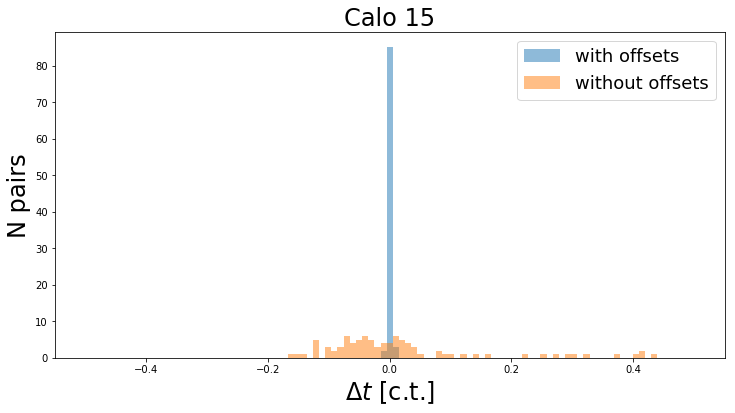

[-8.21483352e-03  8.77435275e-03 -2.07074675e-03 -2.44582456e-03
 -4.33918825e-03  2.73114574e-03 -1.24732855e-03 -3.75823949e-03
  1.33475072e-03 -2.58135724e-03  1.41138160e-03  1.87682309e-04
 -5.33733774e-03  2.26437017e-03  1.07135319e-02 -2.38591193e-03
  2.66344962e-03 -6.27668689e-04  4.22154856e-03 -5.91412228e-04
 -1.21784763e-03  2.20132452e-03 -3.63109040e-03 -7.26282920e-04
  2.58962587e-03 -2.49771802e-03  1.75788736e-03 -1.27514413e-03
 -1.43891330e-03 -1.67366861e-03  1.08705160e-03 -2.38193865e-03
 -5.97105048e-04 -1.39505018e-03  2.16017592e-03 -7.93093735e-04
  4.85401286e-04  2.03363083e-03 -1.41998876e-04 -2.02938117e-03
 -1.38020371e-03  4.56661878e-03  2.24157503e-03 -4.72968384e-03
  6.28837859e-04  1.15601858e-03 -1.58380208e-03  4.52572094e-03
 -3.21818215e-04 -2.24597552e-03 -1.35695608e-03  1.55573470e-05
 -8.32300906e-04  1.07899996e-04  2.39469925e-03  1.18265687e-03
 -3.91048060e-03  5.51443398e-04  6.02955187e-03 -8.10575855e-04
 -2.19002563e-03 -4.56709

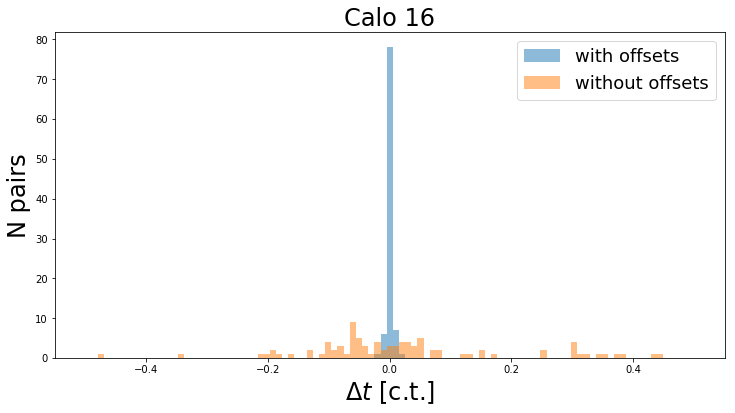

[-1.91406042e-03  2.86664296e-03  7.57659260e-03 -1.02576510e-02
  2.90946780e-03  3.76546300e-03  3.13046877e-03  1.06762428e-03
 -5.94441194e-05  3.24735258e-03  3.00639690e-03 -1.75454730e-03
  1.83123927e-02 -4.12195564e-03  2.39050935e-02  3.54256348e-03
  6.96600532e-03  2.34826547e-04  5.28793534e-04 -3.12758770e-03
 -5.32435121e-04  7.57761396e-04 -4.03543469e-03  2.46782354e-04
  1.86306471e-03  2.70784279e-03 -1.65526014e-03  4.76559128e-03
 -4.19451395e-03  7.21709646e-03 -4.31969068e-03  3.76134162e-03
  3.35920283e-03  3.85455004e-03  2.39583595e-03 -5.25635706e-03
 -1.51111503e-04  4.41592891e-03 -1.34448654e-03 -1.38266924e-03
  3.61267050e-04 -1.96329435e-03 -1.25018341e-03  1.52255828e-03
 -3.22616693e-03  9.62131758e-04 -8.18780746e-03  6.93732581e-03
 -6.13083103e-03  6.08811997e-04 -4.65807409e-03 -1.56788602e-03
 -1.21532879e-03 -1.56885330e-03  5.61812568e-03 -8.58674151e-04
 -2.77896582e-03  2.20086884e-04 -4.71284883e-03  9.79556993e-04
  8.97262884e-05  1.64648

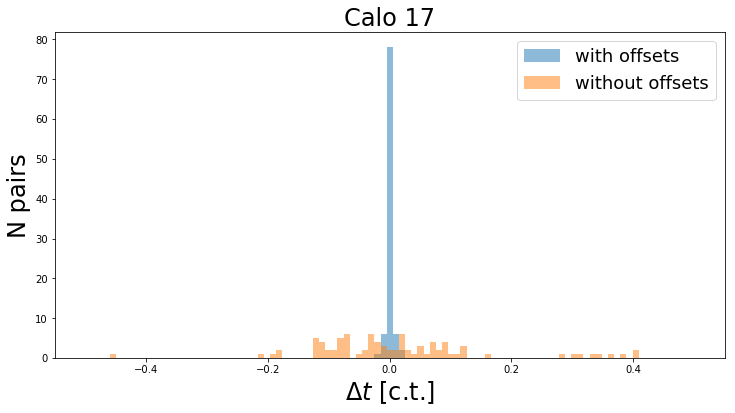

[-1.85674658e-03  2.07456959e-03 -3.37269121e-03  3.81129217e-03
 -1.70882579e-03 -2.28910063e-03  5.20278437e-03 -5.85674171e-03
  8.16754469e-03 -3.91341272e-04 -2.55941330e-03  6.36035831e-03
  9.26637111e-03 -4.30858956e-03  1.66223855e-02  2.86199970e-04
  7.11324328e-03  1.61468564e-03 -2.66392373e-03  3.09714948e-03
 -2.45645643e-04  2.48372641e-03 -3.46513454e-04  1.28866209e-03
 -2.62650398e-03 -1.13799634e-03  3.25929993e-03  2.05869470e-03
 -5.56381156e-04 -2.56827505e-03  2.35797098e-03 -2.49908585e-03
  1.77199229e-04 -8.64547244e-04  5.12662926e-04 -3.61560794e-03
  2.51198905e-03 -5.26388368e-03  8.16380977e-04  2.66698657e-03
 -8.75755418e-04  5.35945558e-04 -5.70745570e-06  1.80214012e-03
 -3.05750564e-03  4.83603594e-03 -1.16829152e-03  1.12147309e-04
  4.17349098e-04 -1.87279436e-03 -1.96953306e-04 -3.12927165e-04
 -3.62975739e-03 -6.43306089e-04 -5.32191890e-03 -3.03272983e-03
  1.06132354e-02 -1.85480613e-03 -1.84547973e-03 -1.11407280e-03
  4.51693187e-04  4.40683

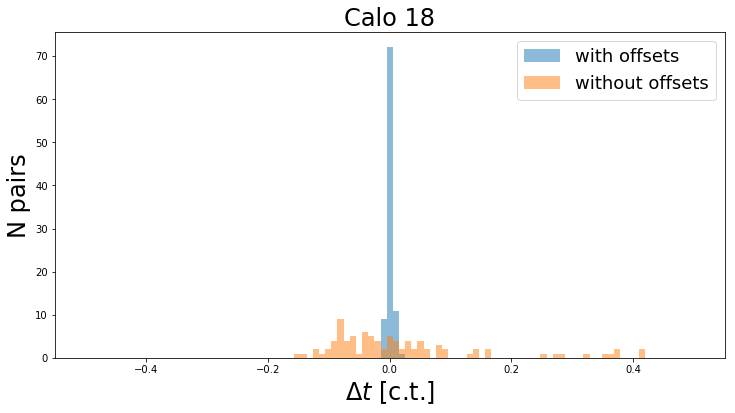

[ 1.18265063e-02 -1.07983769e-02  2.98001442e-02 -1.07365757e-02
  3.24157917e-02 -2.14690823e-03  3.13771466e-02  2.48988812e-03
  2.87139488e-02  8.10715040e-03  2.87792903e-02  1.26207421e-03
  2.36172755e-02  7.33781043e-03  2.51000097e-02  5.41962028e-03
  1.94660186e-02 -2.89511661e-03 -9.20453067e-04 -5.20974521e-03
 -4.88679196e-03 -4.69909334e-03 -7.10313005e-04 -5.33301420e-04
 -5.61959228e-03  4.68441099e-03 -6.60247934e-03  3.84133831e-03
  6.80881444e-04  4.69978912e-03  5.29730949e-06  4.54143327e-03
  1.28741615e-03  5.00383637e-03 -1.27594606e-03  2.15001691e-03
 -3.98092485e-03  2.96881343e-03 -3.60895073e-03 -2.91920212e-03
 -3.44876174e-03 -5.13996515e-03 -3.00905771e-03 -5.12524597e-03
 -5.71474602e-03  6.36391085e-03 -2.07717262e-03 -6.36082327e-03
 -3.76722809e-03  4.09594733e-03  2.79252106e-04 -1.78512737e-03
  7.84096257e-03 -5.79839695e-03  1.37307528e-02 -6.15230101e-03
  2.00052529e-04 -8.22238401e-03  1.65819085e-03 -1.08263545e-02
 -6.70052599e-04 -2.64341

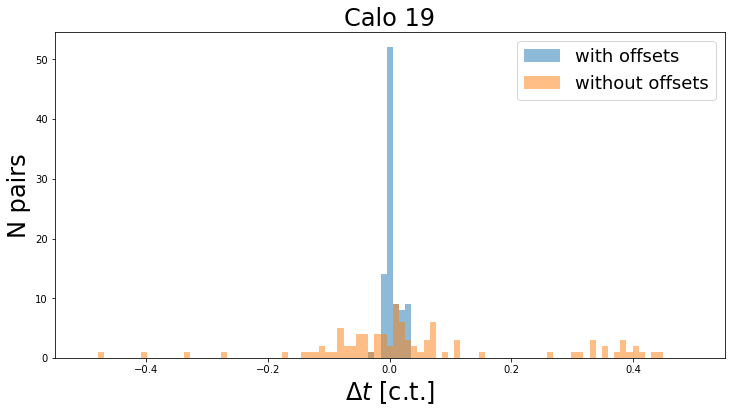

[-2.88251202e-03  3.21541468e-03  2.05765893e-03 -4.25787797e-03
  4.84693186e-03 -5.21909296e-03  7.85969592e-03  1.00308261e-04
  3.61193246e-03  4.41359013e-03  4.63109226e-03  7.98716486e-05
 -4.34201160e-03  3.49630657e-03  1.80566951e-02 -4.45435533e-03
  9.29993529e-03 -1.40929634e-03  3.93467799e-03 -1.06074202e-03
 -3.95129912e-03 -1.85649551e-03 -1.25912134e-03 -5.66149185e-04
 -1.78227625e-03  2.75161901e-05  1.49215520e-03 -7.45553823e-04
  8.31954938e-04  2.45806110e-04  3.47015721e-04 -2.53842929e-03
  1.25747708e-03 -1.01367284e-03  1.47633863e-03  4.65790634e-04
 -1.40843698e-03  1.97378610e-03  4.23304930e-04 -4.97526506e-03
 -1.17031663e-03  1.03008065e-03 -7.75646130e-04  4.77316952e-04
  2.04699884e-03 -3.14908041e-03 -1.64205600e-04  2.78582986e-03
 -2.90957855e-04  1.08316088e-03 -1.18483618e-03  5.46269200e-04
 -7.02778964e-04 -2.28364878e-03  8.15037424e-03 -3.97914288e-03
 -3.16693623e-04 -1.01207315e-03 -3.86597542e-03 -1.09364062e-03
  7.75505001e-04 -3.01499

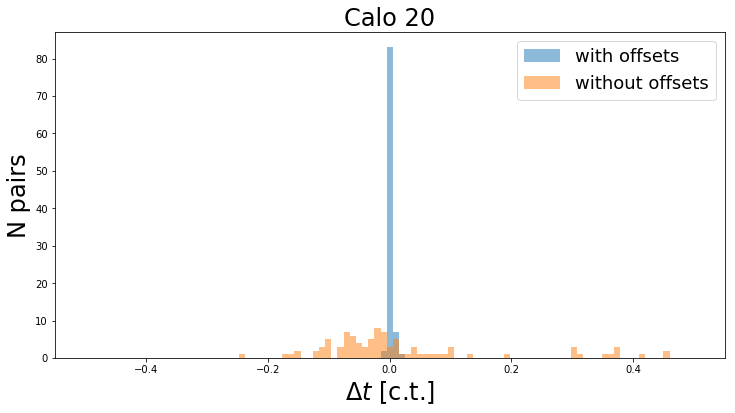

[-9.33381563e-03  6.60644496e-03 -7.04788305e-03  8.49004093e-03
 -1.79186077e-02  9.87271799e-03 -6.14323981e-03 -1.65146563e-02
 -8.55132473e-05 -4.79492727e-03  2.63653887e-03 -1.52228382e-03
 -1.54272221e-03  2.00606877e-03  1.41362298e-02 -2.71323663e-03
  2.66884237e-03  8.23183774e-04  3.88579339e-04  4.00107862e-04
  5.98688926e-03  5.49863706e-03 -2.51030262e-03  3.24263239e-03
 -5.67828608e-03  1.68591292e-03  3.42587129e-04 -1.77230357e-04
  1.27052710e-03  1.65633189e-03 -9.23651947e-04  8.01420389e-04
  1.58050929e-04  7.87632044e-04  6.02787732e-04 -1.07734051e-03
  4.00472204e-03  4.40118521e-04  3.01692156e-03 -1.92010955e-03
 -9.33160379e-05 -2.01101403e-04  1.65325060e-03 -3.14480520e-03
 -4.48985310e-04  5.10196381e-03  2.27382899e-04 -1.77727977e-03
  1.21219614e-03 -1.70404533e-03  1.98061146e-03  6.19090077e-04
 -3.19282858e-03 -6.74657451e-05  1.92990786e-03 -7.69847570e-04
 -2.66964566e-04 -2.04710457e-03  3.04667850e-03 -5.94780840e-03
  6.37291999e-03 -4.90120

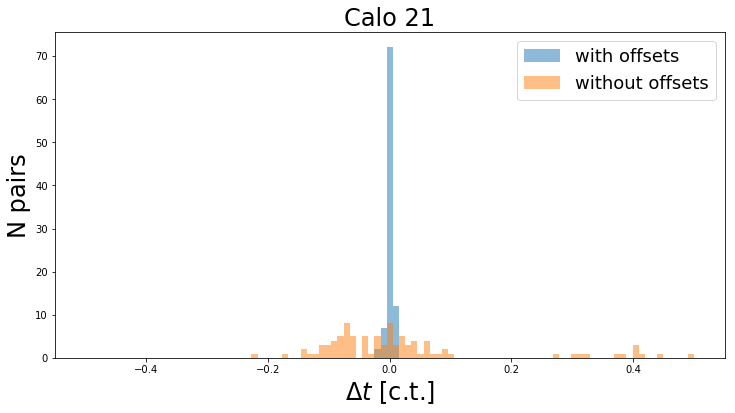

[-1.50485588e-03  2.35378715e-03  9.83601416e-04 -3.97201074e-03
  1.30849900e-04  1.41551564e-03 -6.01388684e-04  9.39290892e-04
 -1.66355849e-04 -5.27532327e-04 -1.28558082e-02  7.53284409e-03
  3.75339922e-03 -1.21824369e-02  1.01383879e-03  5.55111512e-16
 -4.40022436e-03  1.01862276e-02 -2.37918658e-03 -4.03790644e-03
  1.68133427e-03 -7.56214465e-03 -2.00673108e-03  6.71356756e-03
 -2.75000362e-04 -3.31470639e-03 -9.16965390e-04  5.32418587e-03
 -1.31740691e-03 -2.81763461e-03  1.90588353e-03 -3.36797509e-03
  1.12924223e-03  3.31214322e-03  1.52566875e-03  4.32758903e-03
 -1.16565043e-02  7.22216587e-04  3.02738327e-04  3.67090955e-03
 -2.36550210e-04 -1.82594939e-04  3.50075742e-03  6.29030078e-05
  4.85761775e-03  2.73816701e-03 -6.22385354e-03 -1.02310190e-03
  3.28930274e-03 -5.98639114e-05 -2.77141674e-03  7.32499713e-03
 -7.40811503e-03 -4.67283313e-05 -3.89587947e-03 -4.76849027e-03
 -2.67609975e-03 -1.49854753e-03 -2.88076222e-03  4.86844949e-03
 -2.92488024e-03  5.17574

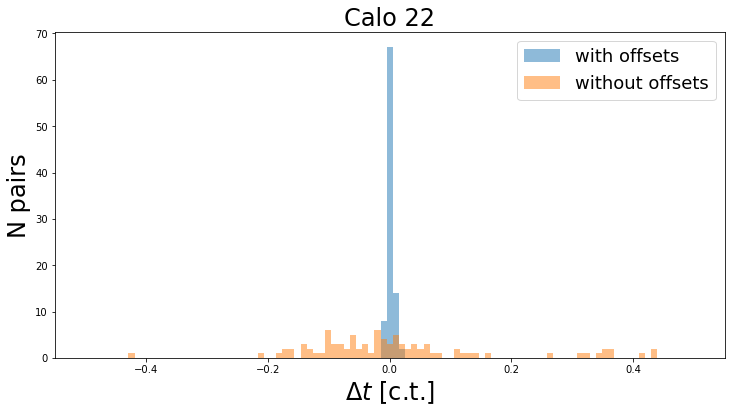

[-6.65746712e-03  9.82985778e-03  6.24553714e-04 -3.80328254e-03
  6.38582771e-03 -5.79463575e-03  3.13328609e-03  2.21029909e-03
  3.43471861e-04  3.03574484e-03 -3.62512532e-03  1.91043221e-03
 -1.38831861e-03 -1.42438621e-03  2.53903720e-02 -1.97054486e-03
  3.93642837e-03 -1.06026704e-03  4.74043055e-03 -1.54850037e-03
 -2.41234442e-03 -2.67226673e-03 -1.91782701e-03  7.78762854e-04
 -4.03066800e-03  2.50394196e-03 -9.29906317e-04 -1.76033836e-04
  3.59391916e-03  3.88485109e-03 -4.21178833e-03  4.24597684e-03
 -1.14805492e-03  3.14241552e-03  1.46057897e-03  1.09212669e-03
  3.39524432e-04  6.44996514e-04  1.36355817e-03 -3.81799447e-03
 -6.09892396e-04 -1.27808719e-04 -1.41542812e-03  1.02932507e-03
 -1.09669969e-04  1.51054126e-03 -1.45887101e-03 -1.99958725e-03
 -2.21344073e-03  7.43175881e-04  2.96680892e-04 -7.88947144e-04
  2.53212685e-03  4.92114619e-04 -2.80833147e-03 -2.59881657e-03
  4.38321394e-03 -2.41539153e-03 -5.20399973e-04 -1.26256310e-03
 -6.95301095e-04  1.08906

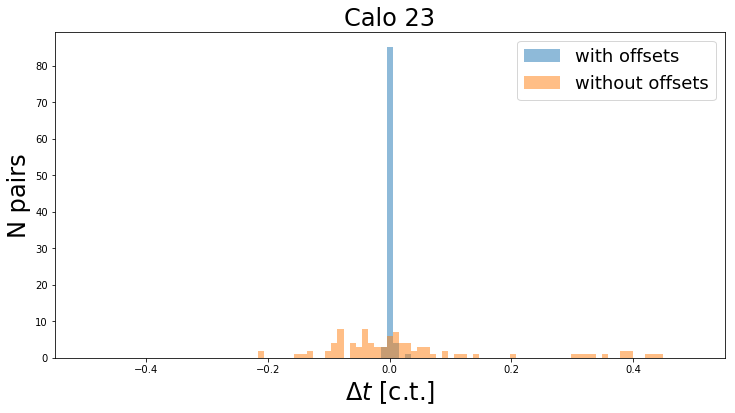

[ 2.01090309e-03 -2.47026008e-03  3.76674242e-03 -4.83359976e-03
  3.06982568e-03  1.38066020e-03  3.16297521e-03  1.08792690e-03
  1.20920046e-02 -2.04995849e-03  1.04431159e-02  1.44237822e-04
  1.03131224e-02  3.44329603e-03  1.99556783e-02 -8.45632761e-04
  1.37365863e-02 -2.04347874e-03  2.22130294e-03 -3.43170625e-03
 -1.12831156e-03 -2.75149993e-03  6.63029934e-04 -1.15672993e-04
 -3.50073045e-03  1.26037090e-03 -2.52894480e-03 -8.49244035e-04
  2.20146858e-03  2.73064433e-03 -2.69512741e-03  1.52706812e-03
  6.11528070e-04  2.02271526e-03  2.56385681e-03 -3.55692050e-03
  4.06168173e-04  3.79188433e-03  1.17599113e-03 -8.81516518e-04
 -1.12188801e-03  8.85995761e-04 -7.27262421e-04 -2.85156257e-03
  1.73638648e-03 -2.40155063e-03  2.80957580e-03 -3.45686341e-03
  2.38704789e-03  7.32172931e-04  3.44172508e-03 -2.69157730e-03
  1.80244257e-03 -2.35203811e-03  3.69820139e-03 -2.03610752e-03
 -1.32616708e-03 -4.09582858e-04 -1.62761393e-03  1.71835748e-04
 -3.91464135e-03 -2.49929

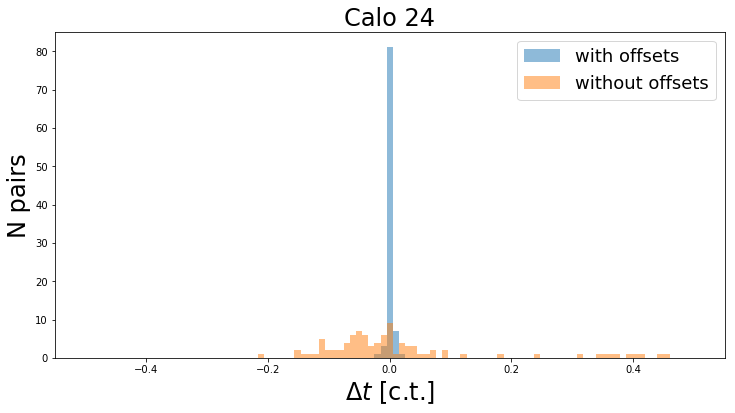

In [14]:
bins = np.linspace(-0.5, 0.5, 100)
for calo_num in range(1, 25):
    before, after = compare_dts(calo_num, start_corner='br')
    #print(after)
    plt.hist(after, bins=bins, label='with offsets', alpha=0.5)
    plt.hist(before, bins=bins, label='without offsets', alpha=0.5)
    plt.legend(fontsize=18)
    plt.title(f'Calo {calo_num}', fontsize=24)
    plt.xlabel('$\Delta t$ [c.t.]', fontsize=24)
    plt.ylabel('N pairs', fontsize=24)
    plt.show()

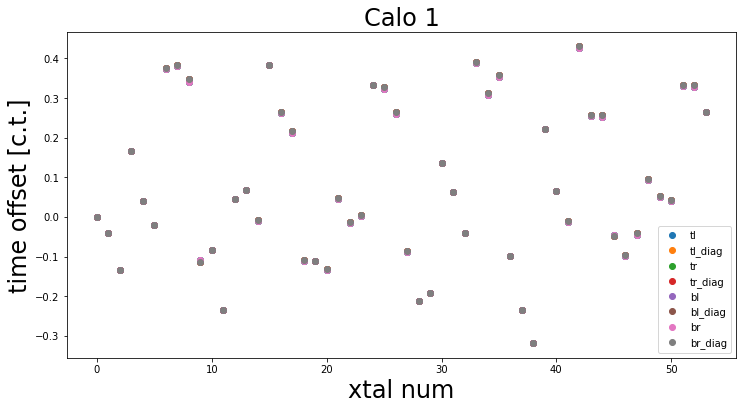

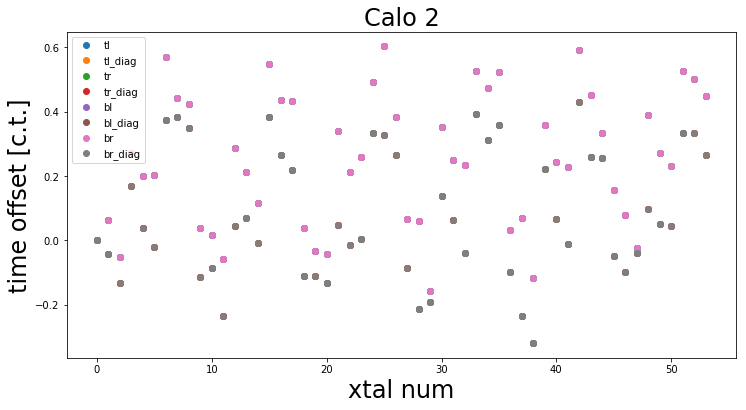

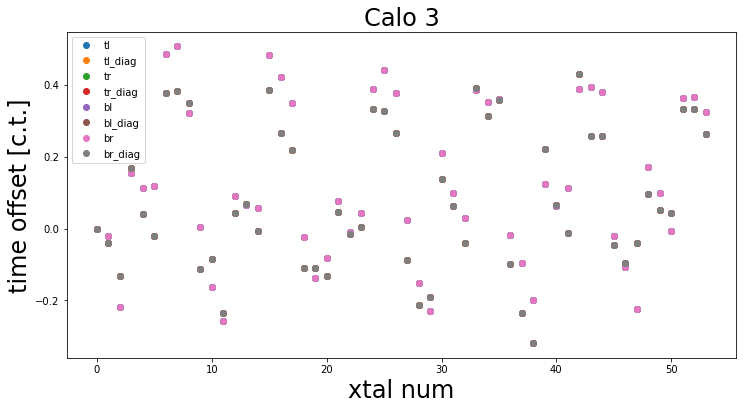

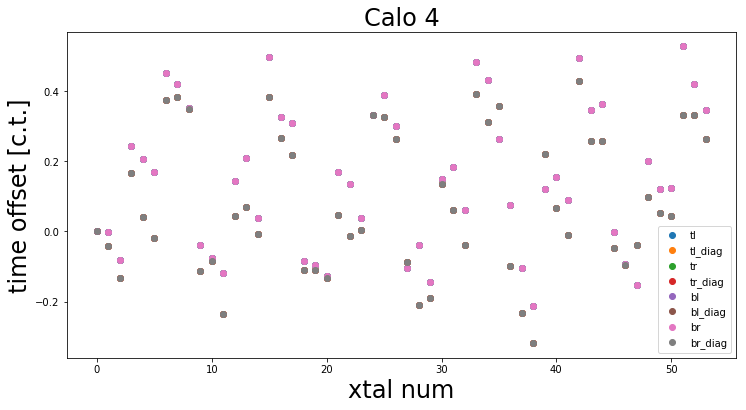

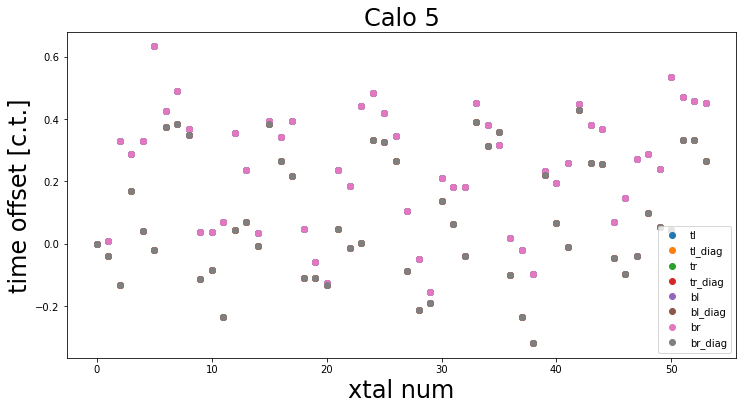

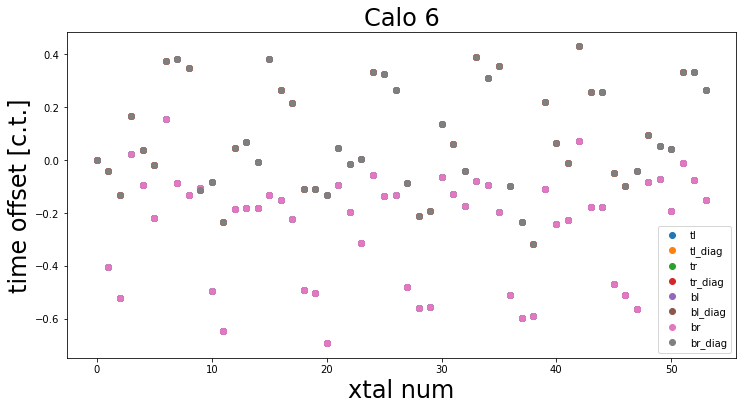

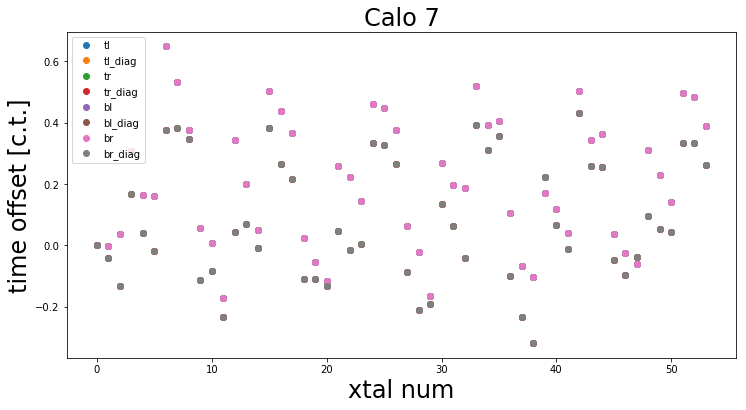

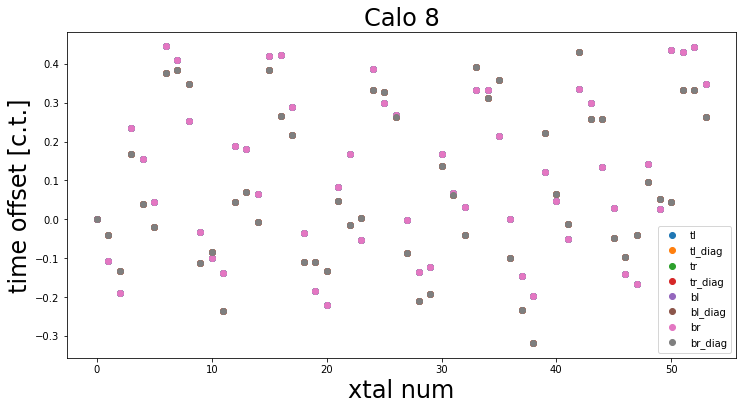

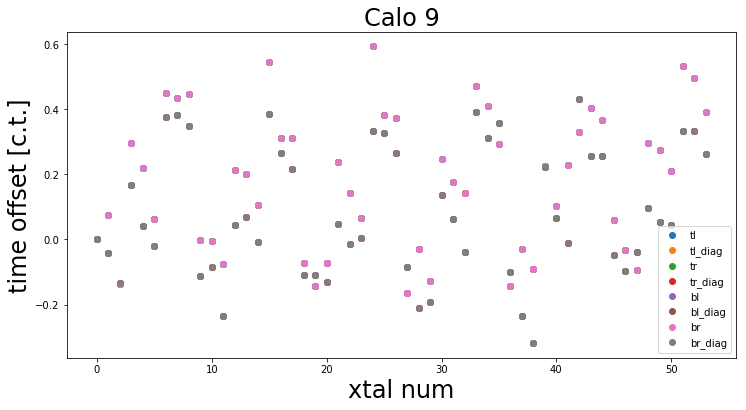

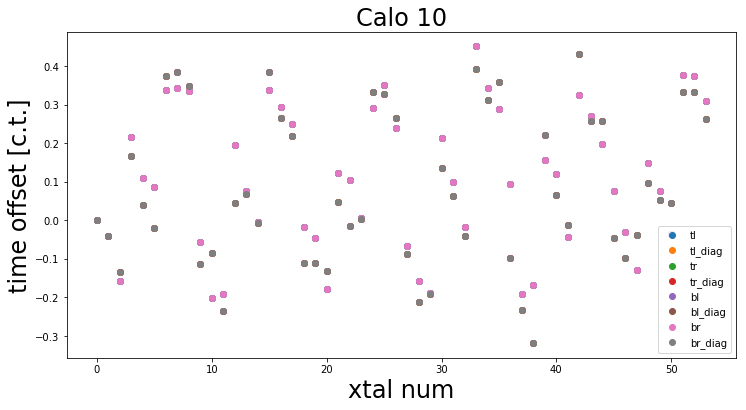

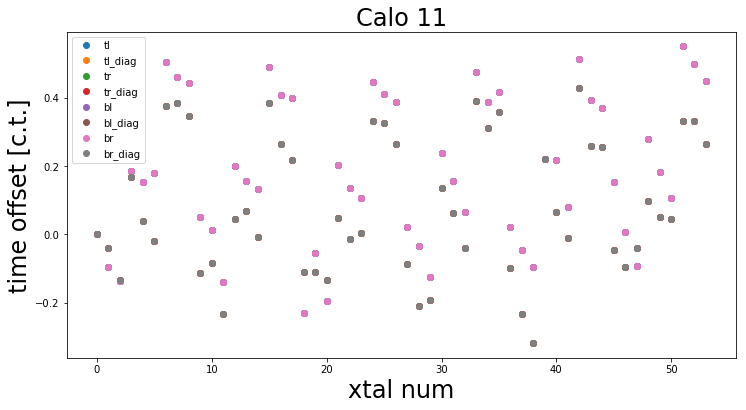

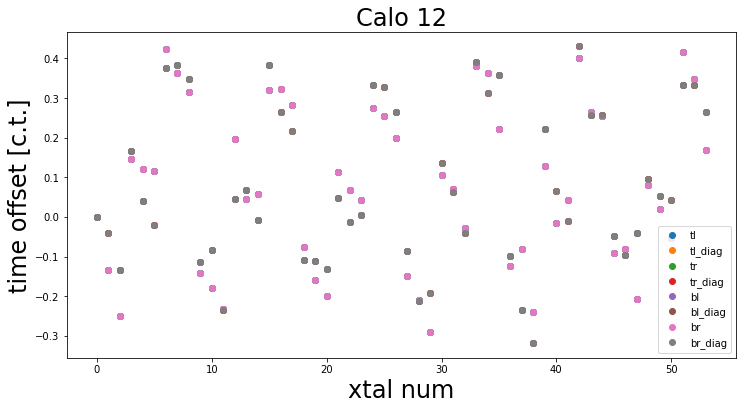

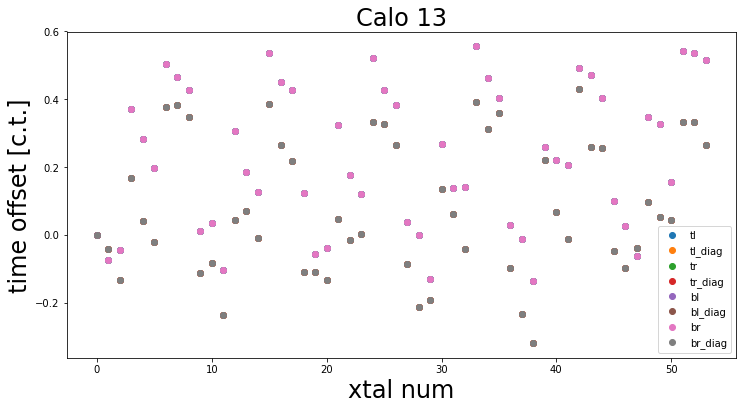

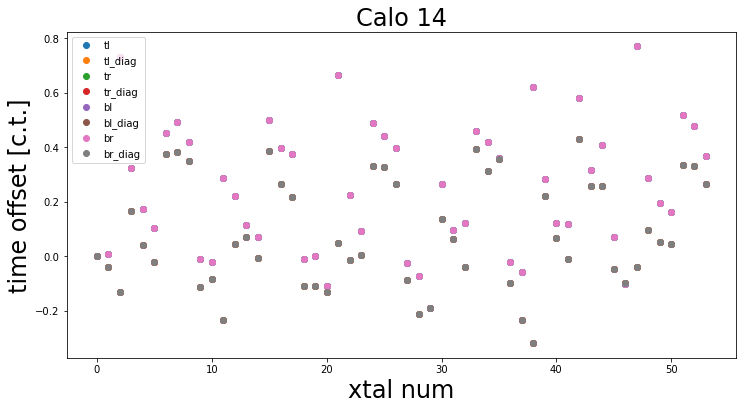

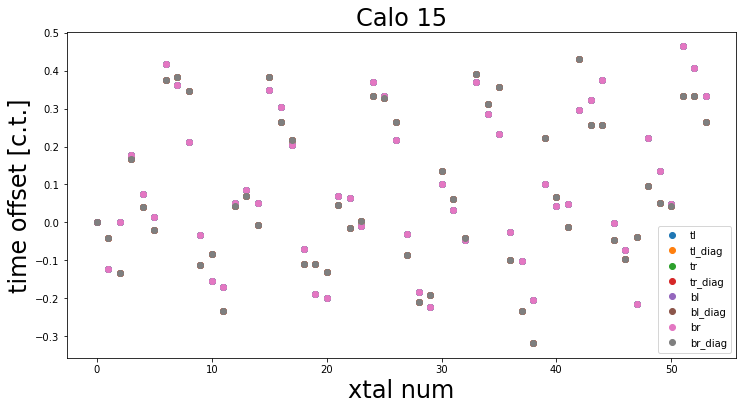

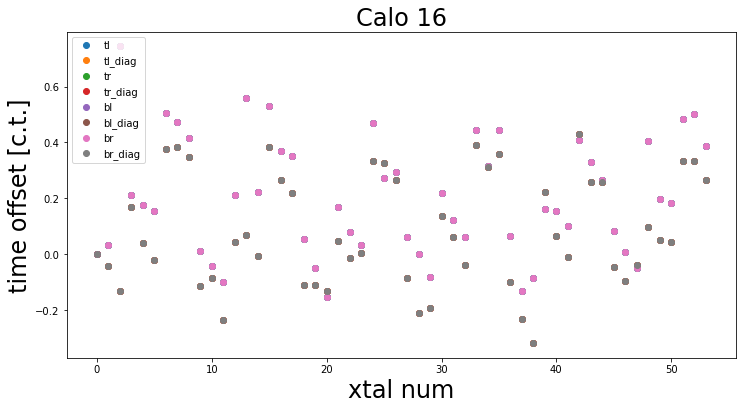

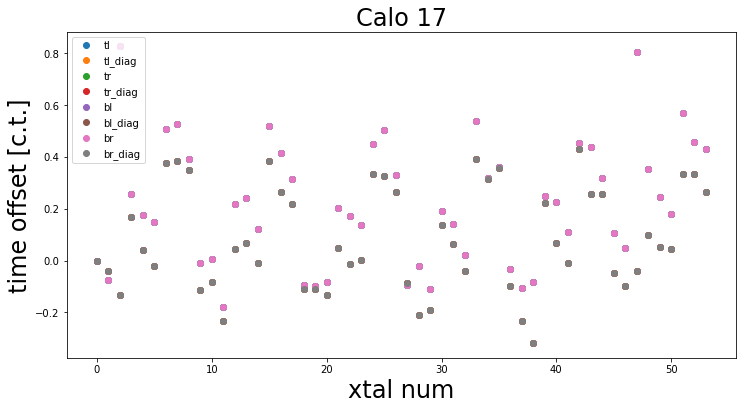

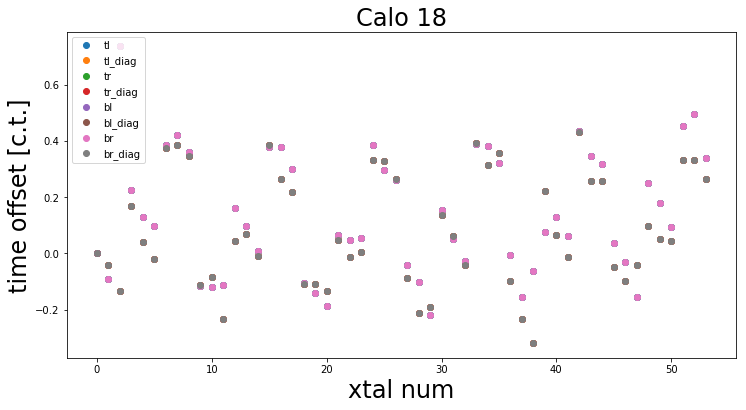

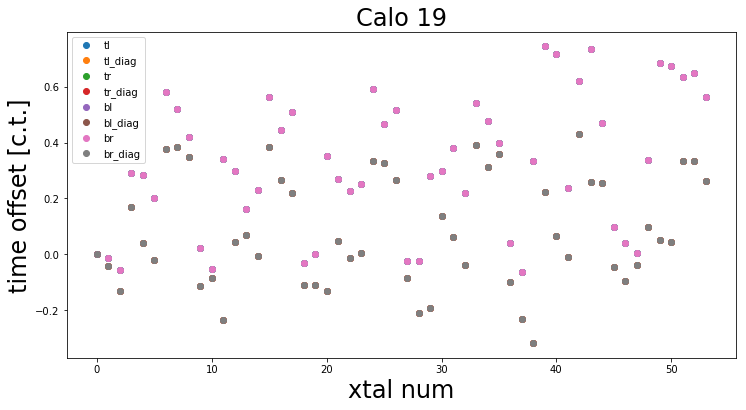

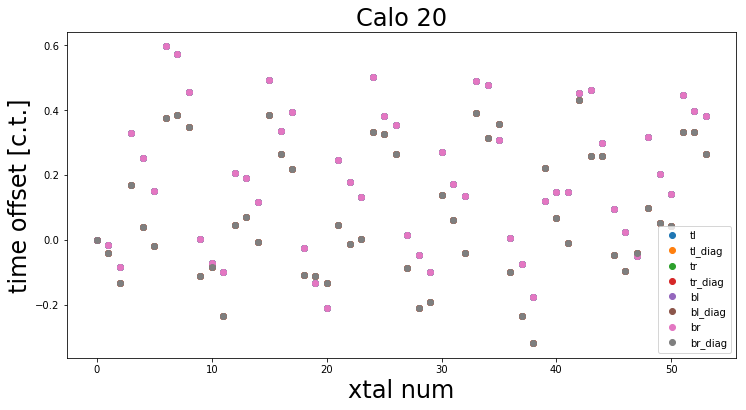

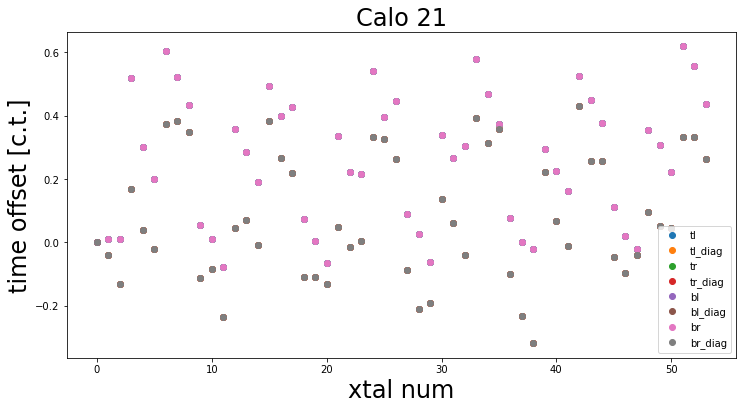

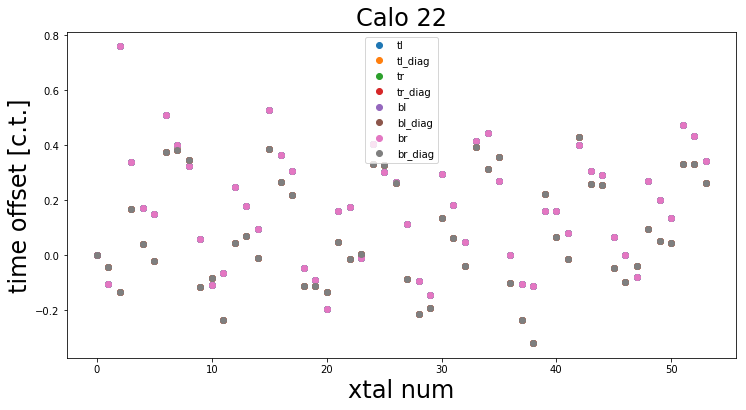

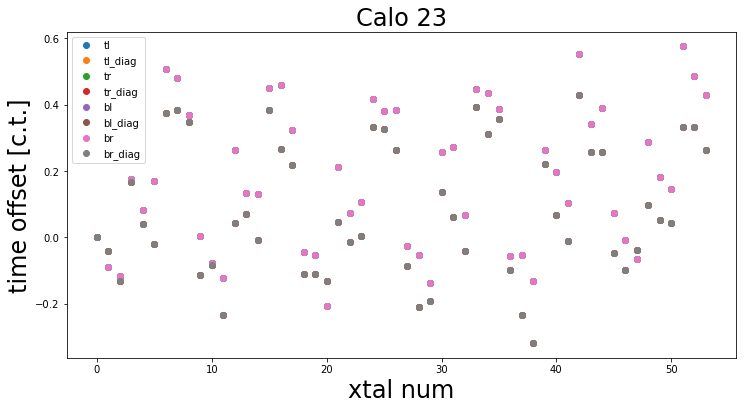

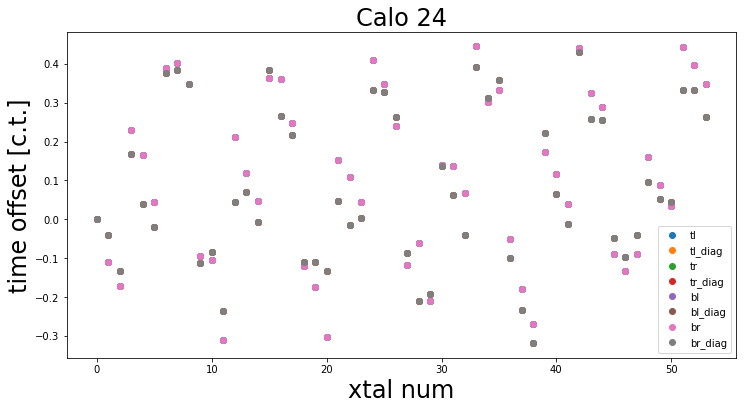

In [15]:
allCaloOffsets = []
for calo_num in range(1, 25):
    for start_corner in ['tl', 'tr', 'bl', 'br']:
        offsets, chi2 = solve_dts(calo_num, fixed_xtal_num=0, 
                                  include_diagonals=False, start_corner=start_corner)
        allCaloOffsets.append(offsets)
        plt.plot(np.arange(54), offsets, 'o', label=start_corner)
        offsets, chi2 = solve_dts(1, fixed_xtal_num=0, 
                                  include_diagonals=True, start_corner=start_corner)
        plt.plot(np.arange(54), offsets, 'o', label=start_corner+'_diag')    
    plt.legend()
    plt.xlabel('xtal num', fontsize=24)
    plt.ylabel('time offset [c.t.]', fontsize=24)
    plt.title(f'Calo {calo_num}', fontsize=24)
    plt.show()

In [19]:
allCaloOffsets = np.array(allCaloOffsets)
np.savetxt("./data/aaronConstants.txt",allCaloOffsets)

### Verify that changing the fixed crystal does not affect the ultimate $\Delta$t values:

In [20]:
before_0, after_0 = compare_dts(calo_num)
before_53, after_53 = compare_dts(calo_num, fixed_xtal_num=53)
print(np.allclose(after_0, after_53))

True


### Plot time offsets by column

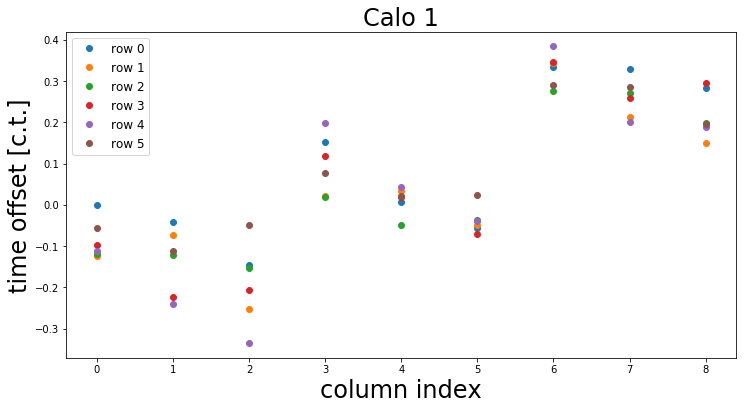

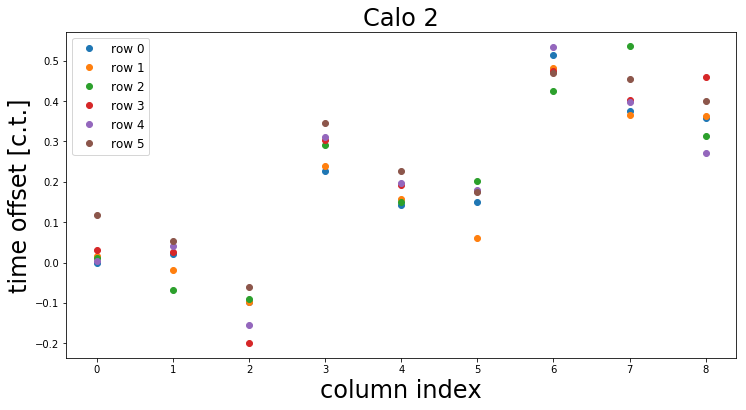

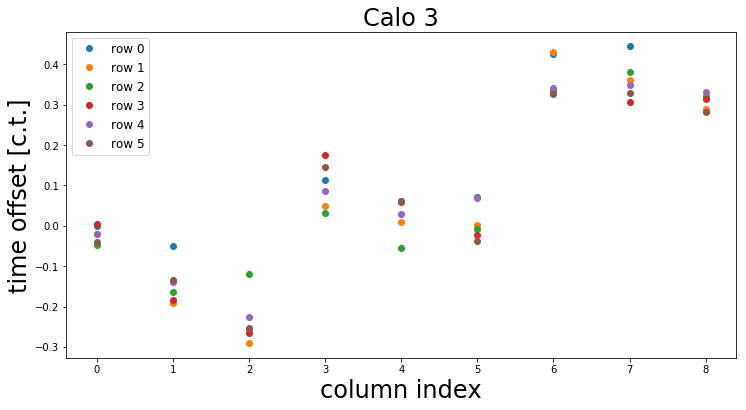

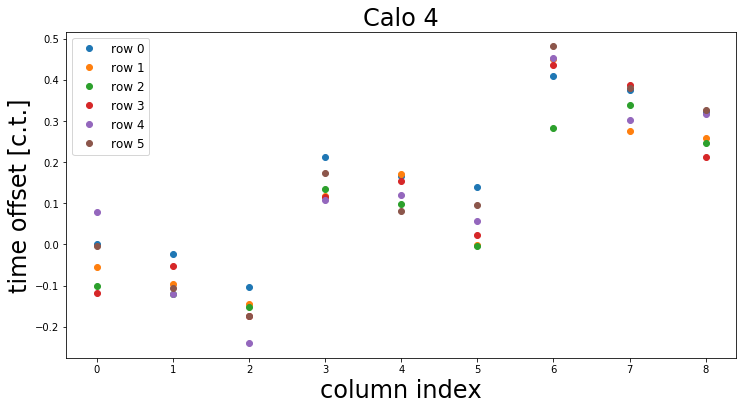

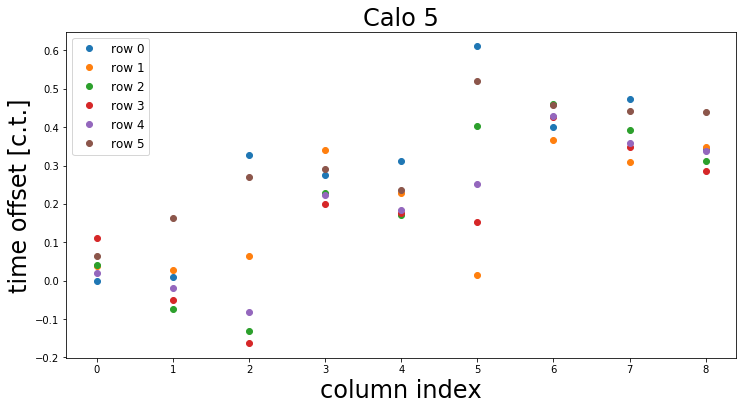

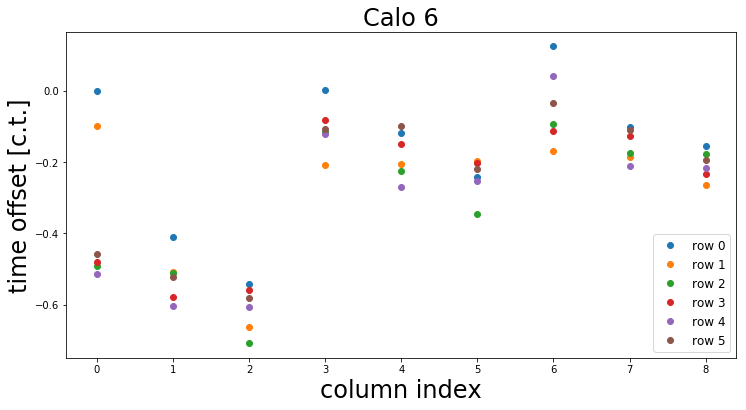

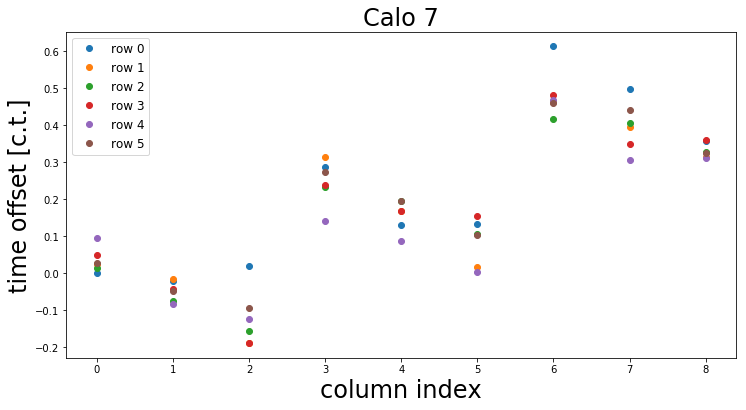

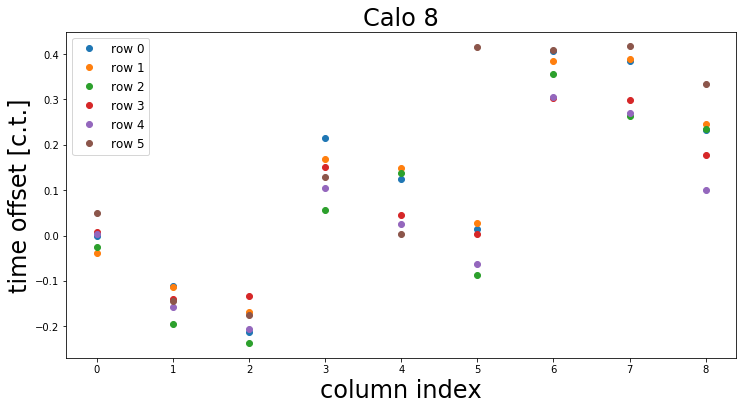

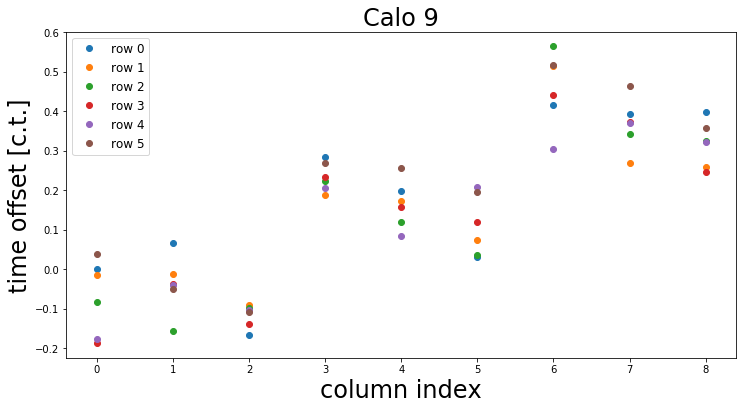

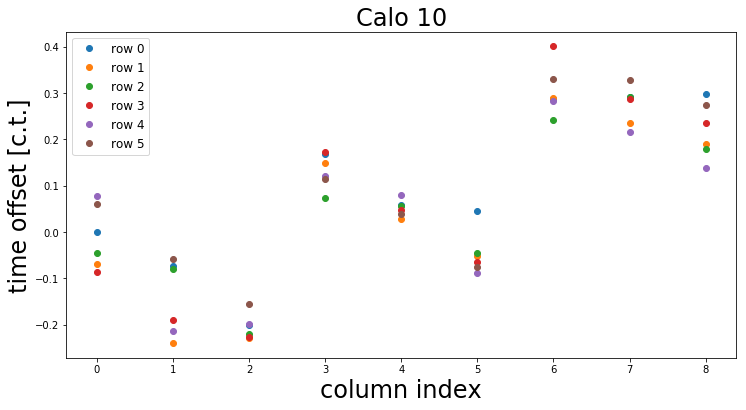

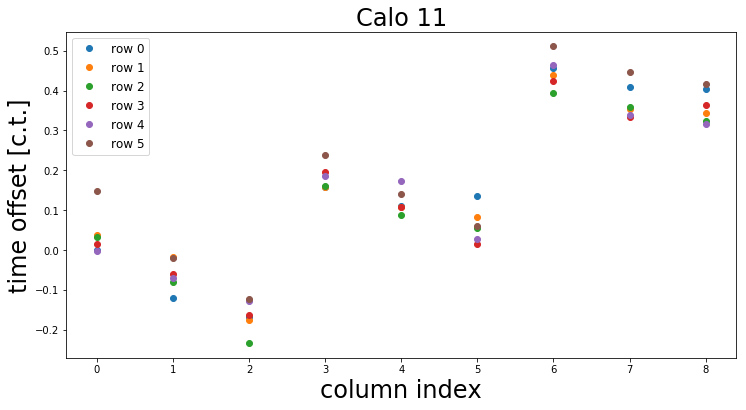

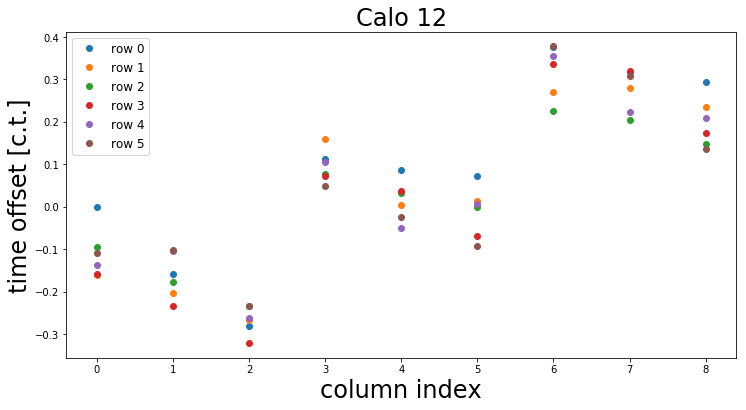

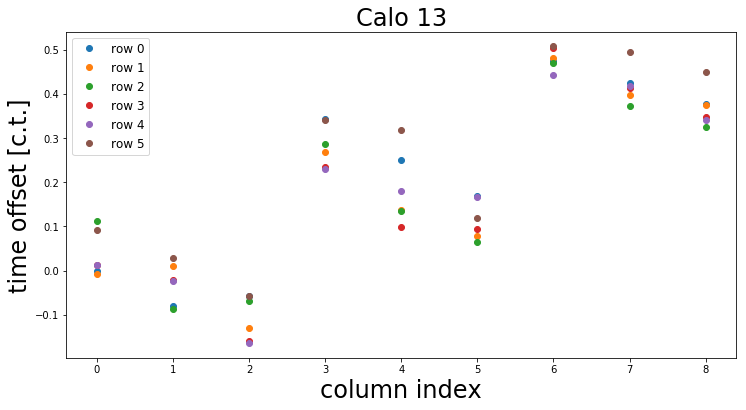

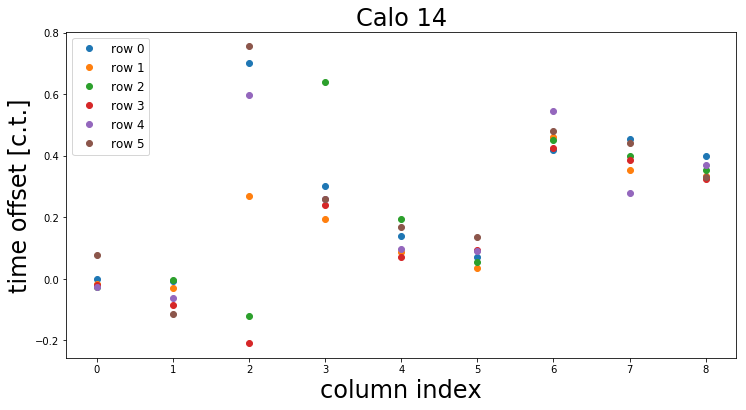

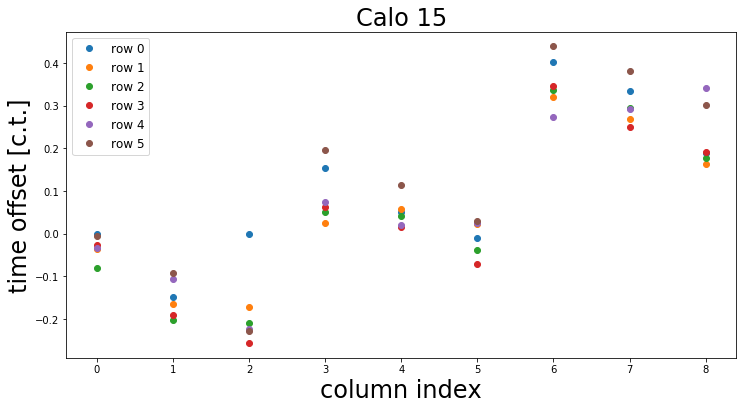

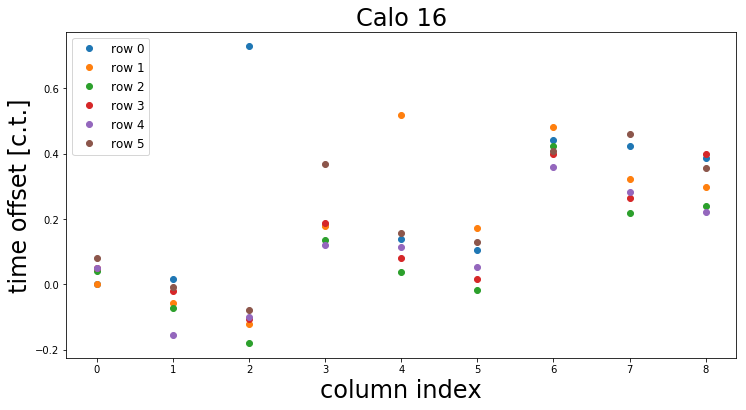

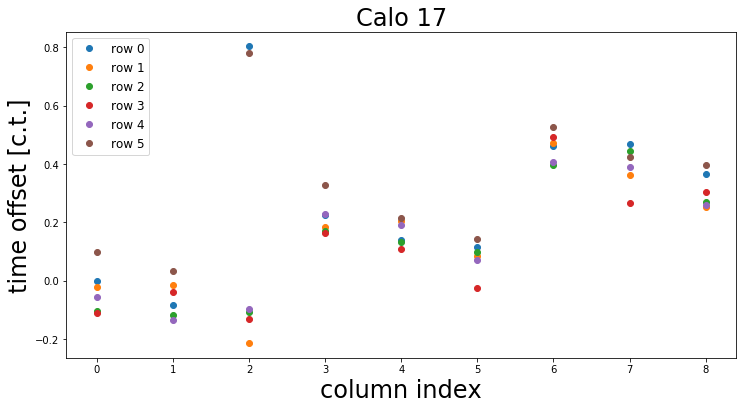

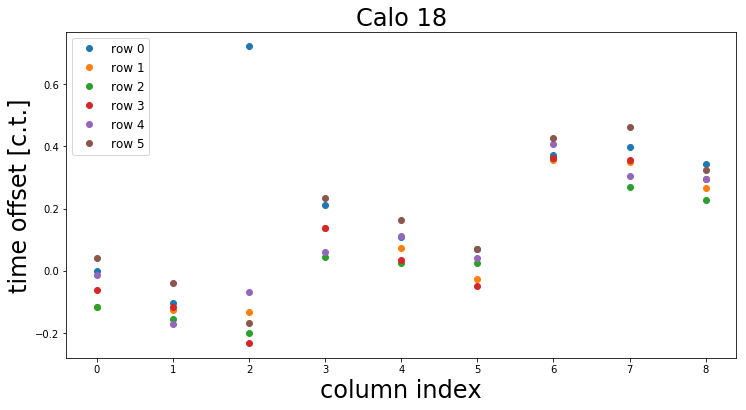

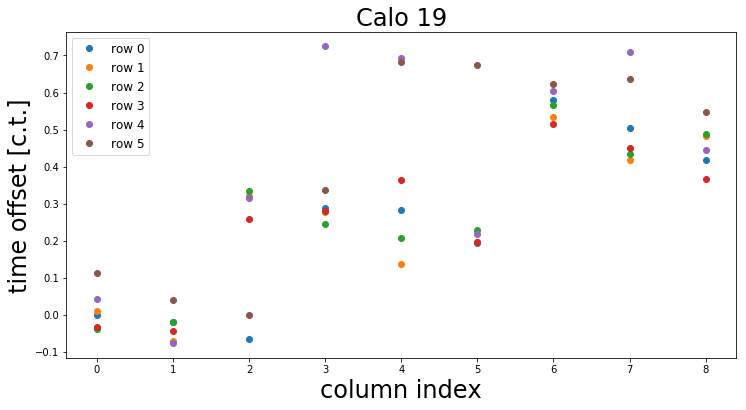

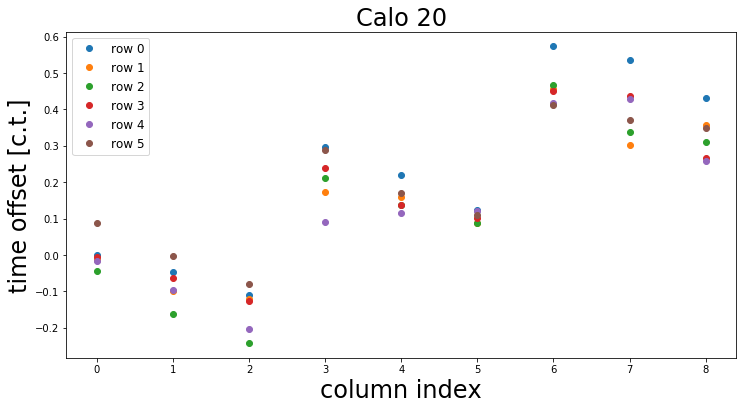

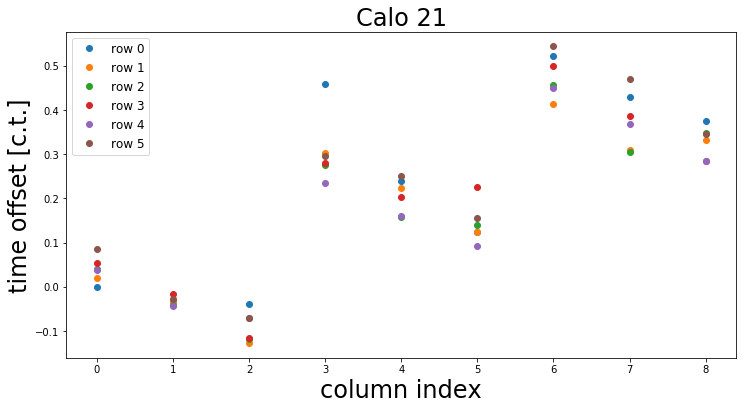

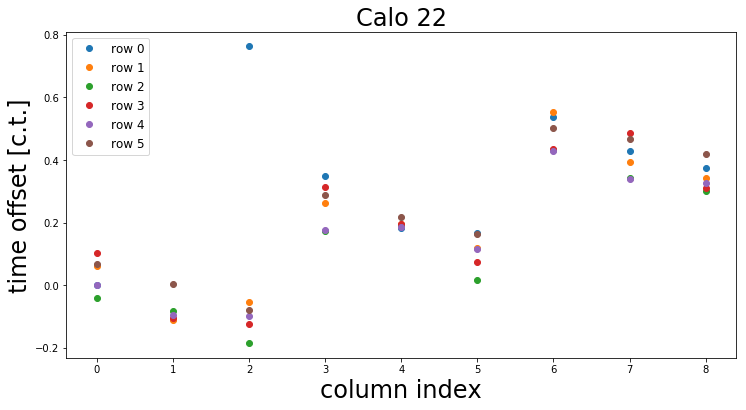

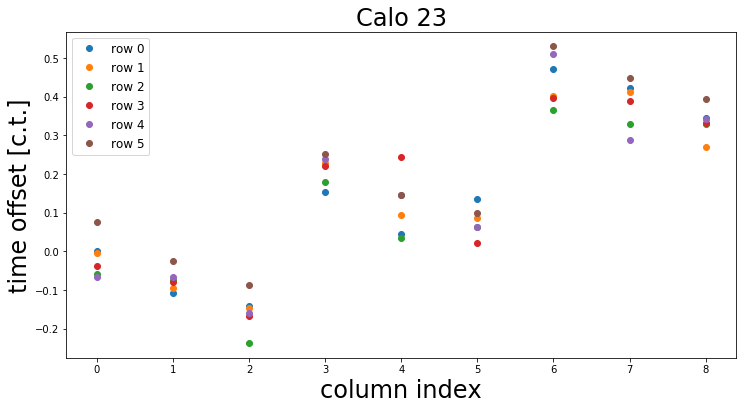

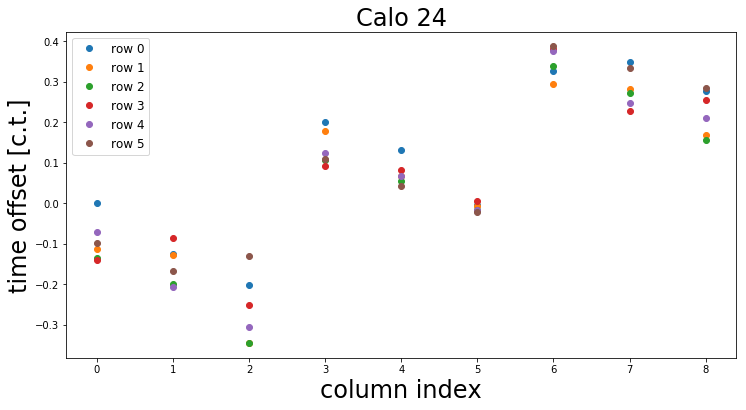

In [13]:
for calo_num in range(1, 25):
    # separate by row and plot by column
    offsets, chi2 = solve_dts(calo_num)
    offsets_mat = offsets.reshape((6, 9))
    col_nums = np.arange(9)
    for row_num, row in enumerate(offsets_mat):
        plt.plot(col_nums, row, 'o', label=f'row {row_num}')

    plt.legend(fontsize=12)
    plt.title(f'Calo {calo_num}', fontsize=24)
    plt.xlabel('column index', fontsize=24)
    plt.ylabel('time offset [c.t.]', fontsize=24)
    plt.show()

### Plot time offsets by row

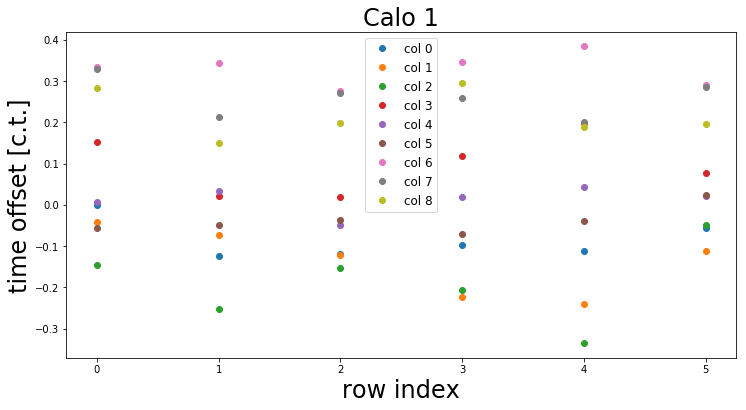

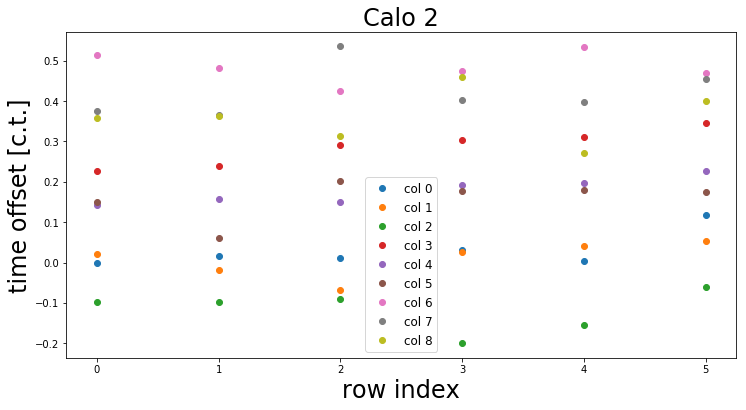

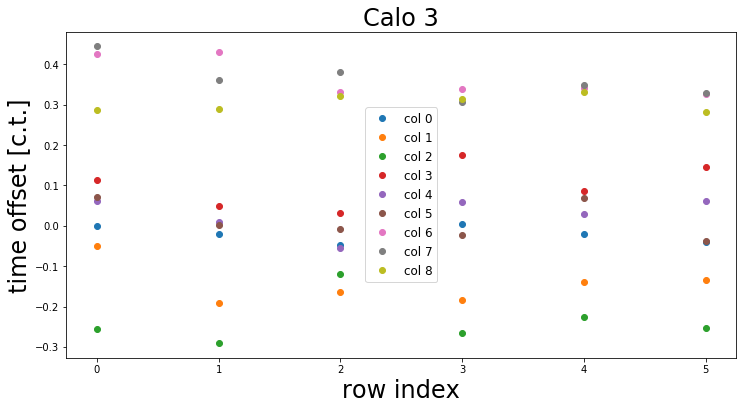

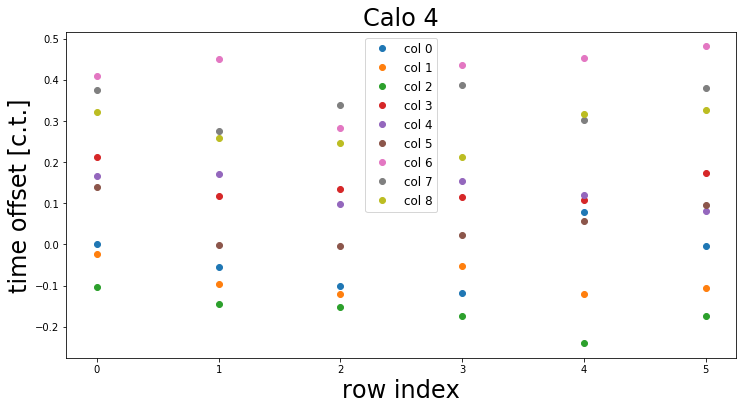

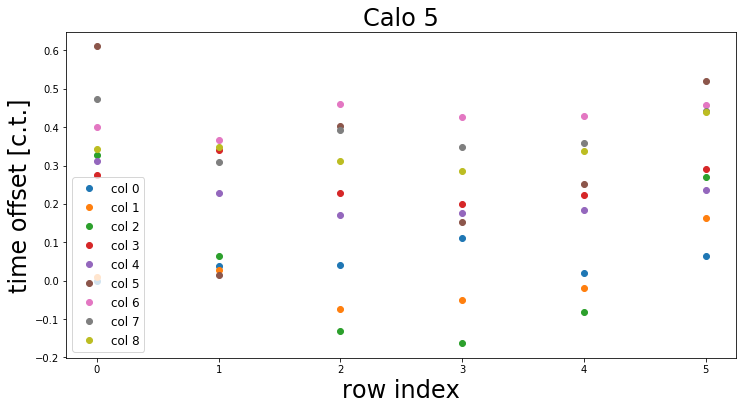

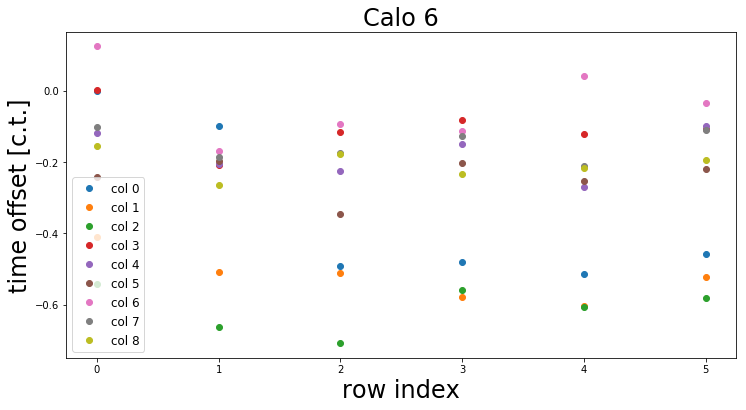

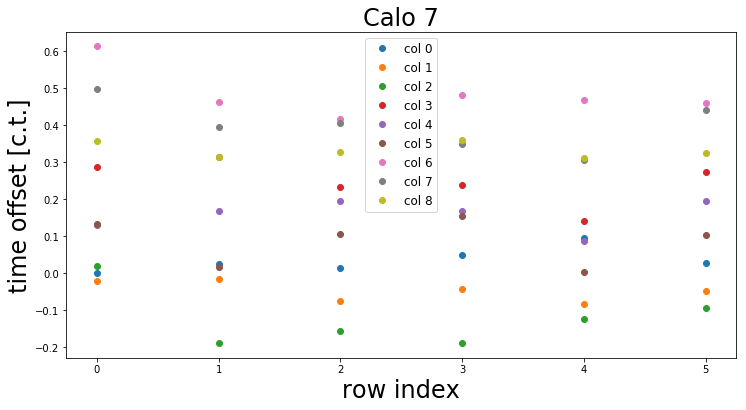

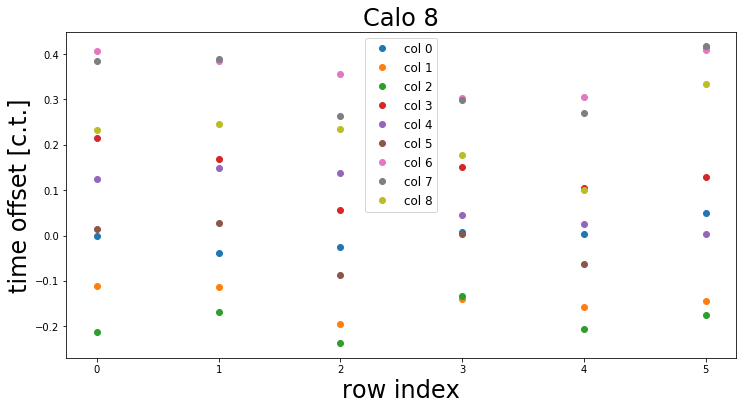

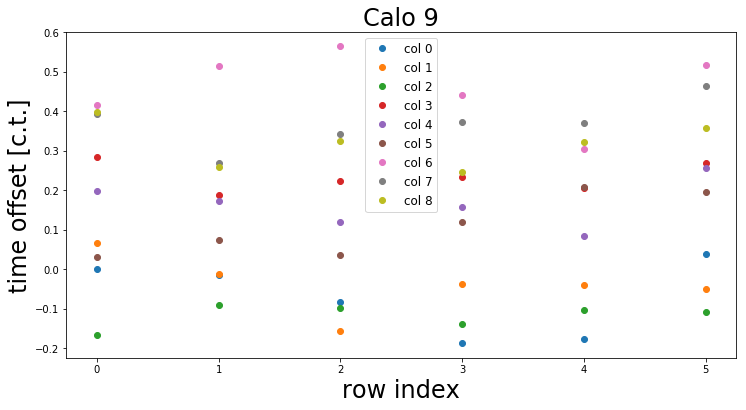

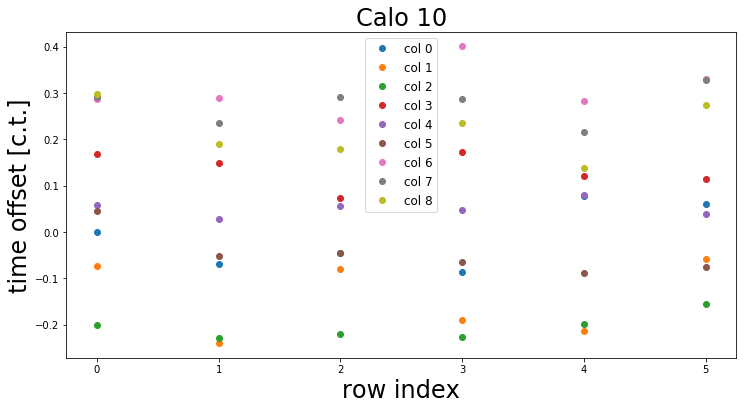

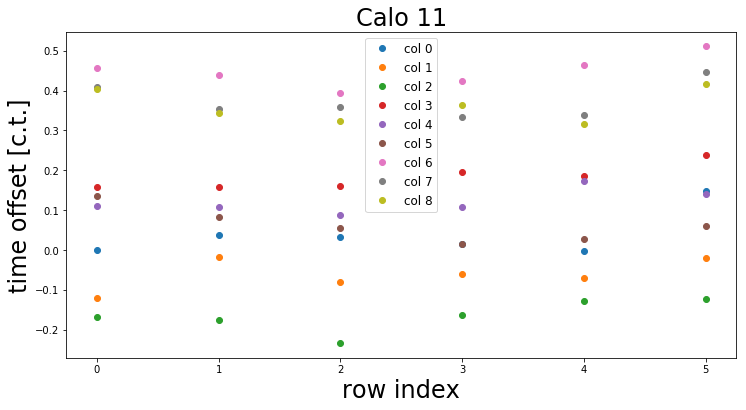

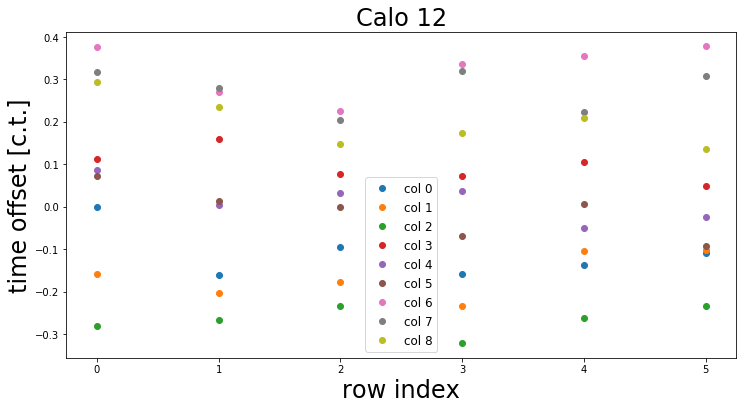

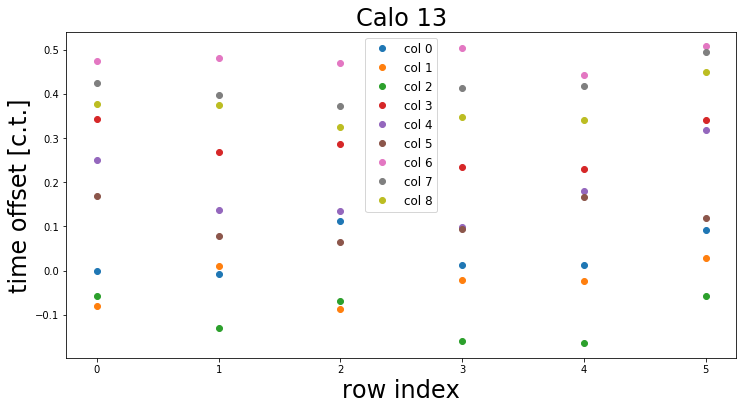

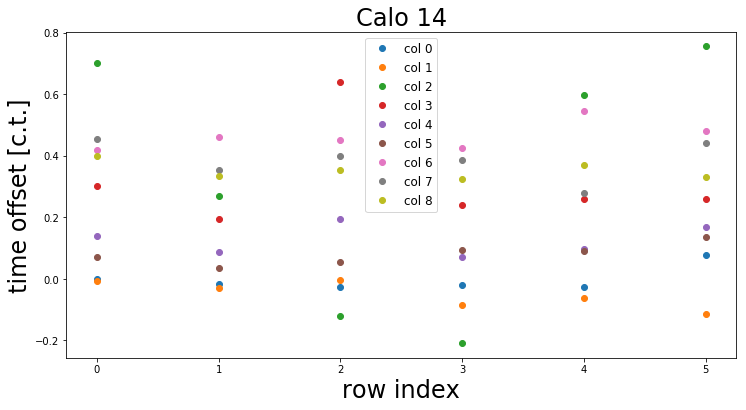

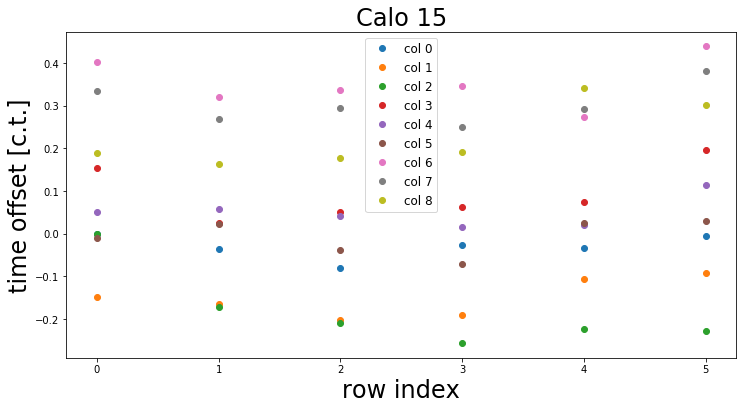

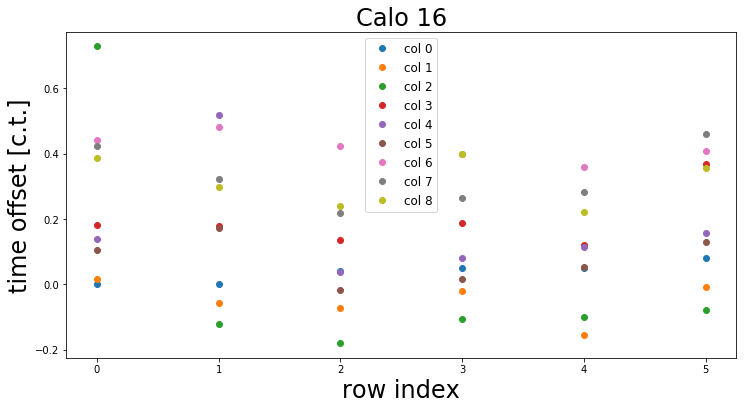

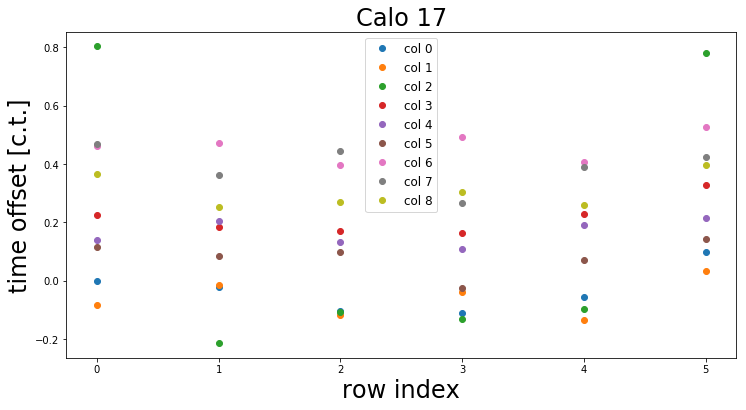

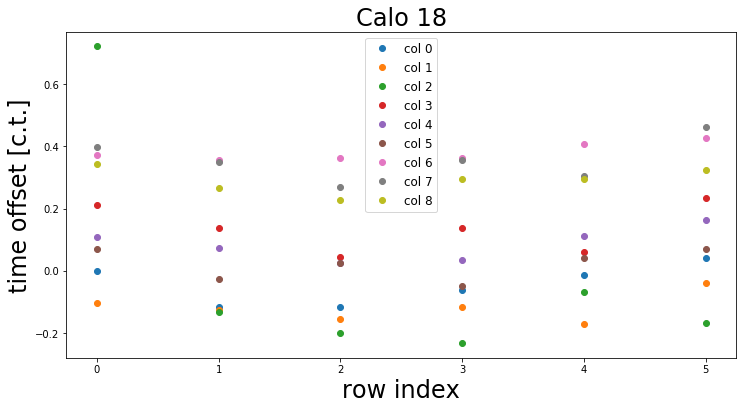

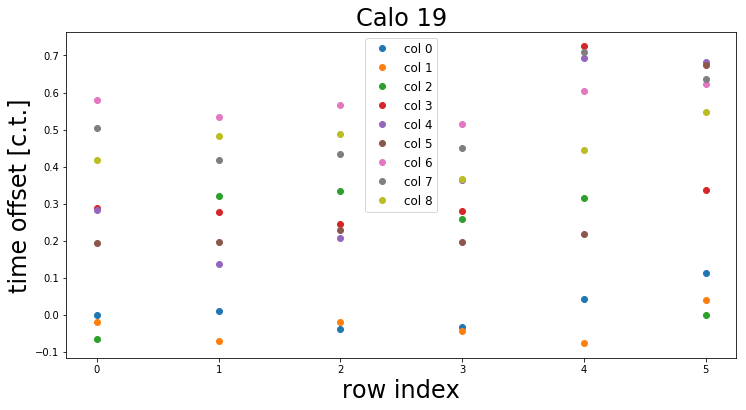

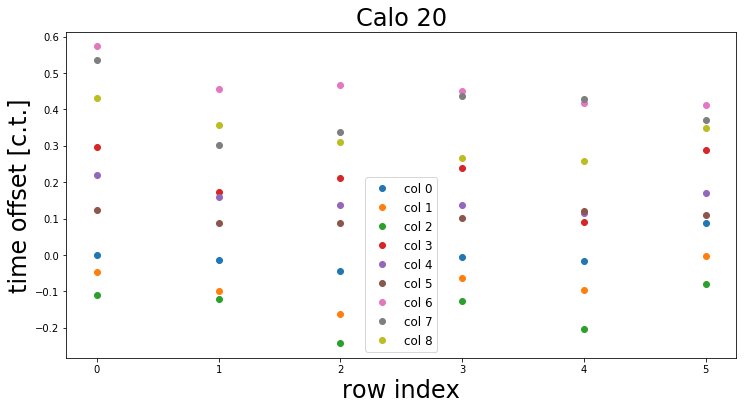

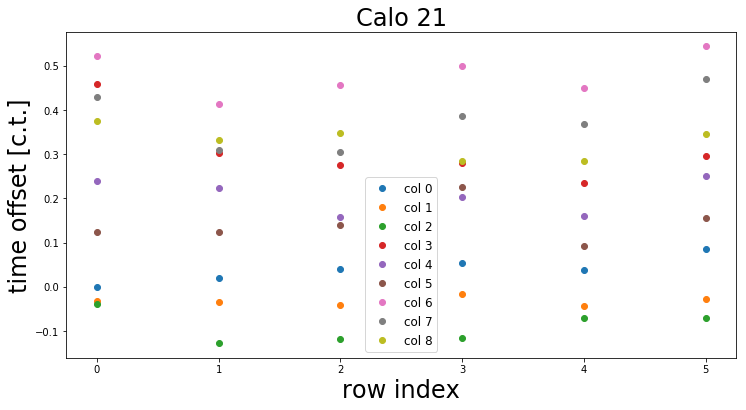

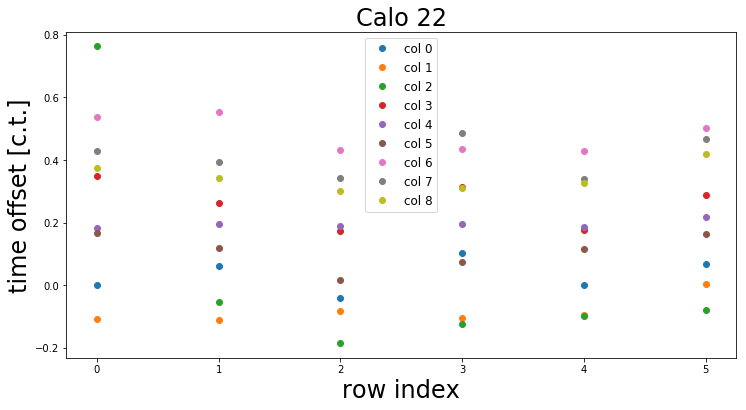

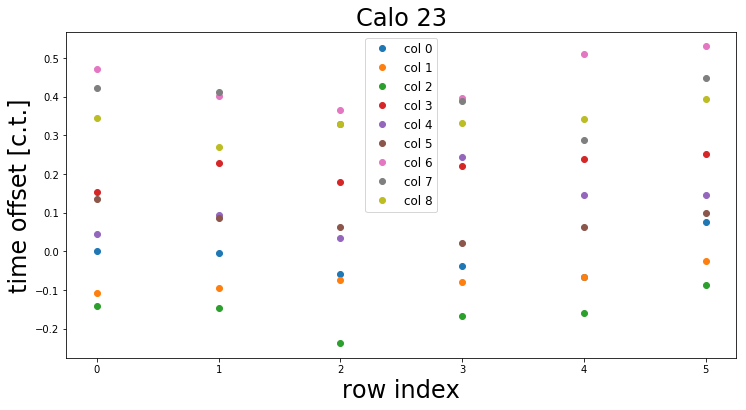

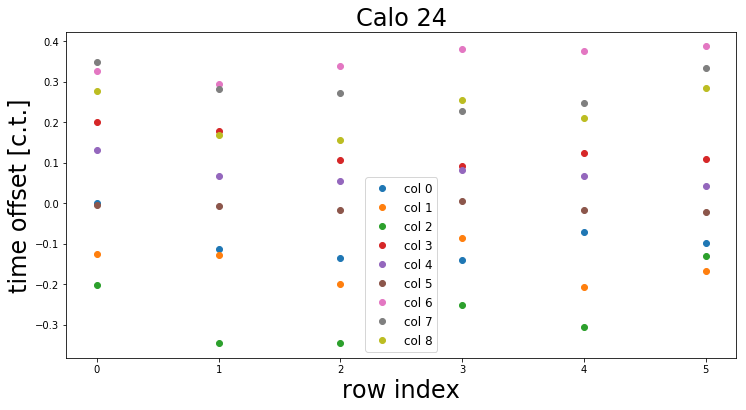

In [14]:
for calo_num in range(1, 25):
    # separate by column and plot by row
    offsets, chi2 = solve_dts(calo_num)
    offsets_mat = offsets.reshape((6, 9)).T
    row_nums = np.arange(6)
    for row_num, row in enumerate(offsets_mat):
        plt.plot(row_nums, row, 'o', label=f'col {row_num}')

    plt.legend(fontsize=12)
    plt.title(f'Calo {calo_num}', fontsize=24)
    plt.xlabel('row index', fontsize=24)
    plt.ylabel('time offset [c.t.]', fontsize=24)
    plt.show()